# Hospitalization. Medical Center Data Analysis

## Introduction

### Project Descriptioon

Saint-Petersburg Pediatric University provides hospitalization data for the period 2019-2023 to define factors that impact the speed of patient's admission to the hospital and run Ad-hoc study on information that may be useful.

### Project goal and objectives

Project goal: define factors that impact the lag between referral and admission dates.

Objectives:
- load data;
- explore and prepare data;
- discover data;
- define factors that impact the lag between referral and admission dates to the hospital, analyse correlation;
- test hypotheses ;
- formulate conclusions;
- run Ad-hoc study on:
  - incorrect refferal date;
  - treatment duration;
  - diagnosis change;
  - season factor.

## Data exploration and preparation

### Libraries

In [1]:
#Load library for correlation assessment between categorical quantitative variables
!pip -q install phik


In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
import time
from scipy import stats as st
from scipy.stats import spearmanr
from datetime import datetime, timedelta
pd.set_option('display.max_colwidth', None) # Отключим усечение ячеек
import plotly.express as px
import psycopg2
import phik

### Data load

In [4]:
beds_connection = psycopg2.connect(dbname='hospital_db', user='***', password='***', host='***', port=5432)
beds = pd.read_sql('SELECT * FROM beds;', con=beds_connection)


In [5]:
# Define function to print table head
def information (table):
    for df in [table]:
        display(df.head(5)),
        display(df.info()),
        print('Row duplicates detected -', table.duplicated().sum())

In [6]:
beds_info = information (beds)

,index,referral_date,income_date,outcome_date,user_id,is_num,code,region,payer,fin_source,dept,profile,bed_days,is_plan,income_mkb,outcome_mkb
0,26048,22.10.2019,30.10.2019,08.11.2019,1.004859e+09,24756,12.3.0,Хабаровский край,Клинические апробации,Клинические апробации,Педиатрическое отделение №3,Ревматологические,10.0,Плановая,Q78.8,Q78.0
1,26049,30.10.2019,30.10.2019,01.11.2019,2.237600e+08,24754,6.1.0,None,Высокотехнологичная медицинская помощь,ВМП,Гастроэнтерологическое отделение,Гастроэнтерологические,3.0,Экстренная,K50.8,K50.8
2,26050,None,30.10.2019,03.12.2019,1.036327e+09,24762,5.99.0,Ставропольский край,Фонд-Иногородние,ОМС,ПЦ Отделение патологии новорожденных и детей грудного возраста,Патологии новорожденных и недоношенных детей,34.0,Экстренная,J44.8,J44.8
3,26051,None,30.10.2019,07.11.2019,1.036332e+09,24767,5.13.1,None,"СПб филиал ООО ""СМК РЕСО - Мед""",ОМС,Педиатрическое отделение №2,Пульмонологические,9.0,Экстренная,J15.8,J15.8
4,26052,30.10.2019,30.10.2019,12.11.2019,3.951390e+08,24755,6.1.0,Краснодарский край,Высокотехнологичная медицинская помощь,ВМП,Гастроэнтерологическое отделение,Гастроэнтерологические,13.0,Плановая,K50.8,K50.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179559 entries, 0 to 179558
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          179559 non-null  int64  
 1   referral_date  99084 non-null   object 
 2   income_date    179559 non-null  object 
 3   outcome_date   179254 non-null  object 
 4   user_id        179266 non-null  float64
 5   is_num         179559 non-null  int64  
 6   code           179559 non-null  object 
 7   region         82008 non-null   object 
 8   payer          179559 non-null  object 
 9   fin_source     179559 non-null  object 
 10  dept           179266 non-null  object 
 11  profile        179266 non-null  object 
 12  bed_days       179254 non-null  float64
 13  is_plan        179559 non-null  object 
 14  income_mkb     179529 non-null  object 
 15  outcome_mkb    179249 non-null  object 
dtypes: float64(2), int64(2), object(12)
memory usage: 21.9+ MB


None

Row duplicates detected - 0


### Datatype correction

In [7]:
for col in ['referral_date', 'income_date', 'outcome_date']:
    beds[col] = pd.to_datetime( beds[col], dayfirst=True)

Datatypes corrected.

### Gaps search

In [8]:
# Search for gaps
beds.isna().sum()

index                0
referral_date    80475
income_date          0
outcome_date       305
user_id            293
is_num               0
code                 0
region           97551
payer                0
fin_source           0
dept               293
profile            293
bed_days           305
is_plan              0
income_mkb          30
outcome_mkb        310
dtype: int64

In [9]:
test_df = beds.copy(deep=True)

In [10]:
# Calculate gaps percentage
test_df.isna().mean().nlargest(3).round(2) * 100

region           54.0
referral_date    45.0
outcome_mkb       0.0
dtype: float64

In [11]:
# Delete gaps for user_id
beds = beds.dropna(subset=['user_id'])

In [12]:
# Check cleared data
beds.isna().sum()

index                0
referral_date    80182
income_date          0
outcome_date        12
user_id              0
is_num               0
code                 0
region           97258
payer                0
fin_source           0
dept                 0
profile              0
bed_days            12
is_plan              0
income_mkb          14
outcome_mkb         17
dtype: int64

### Duplicates check

#### Rows duplicates

In [13]:
# Check for duplicates by 'user_id','income_date','outcome_date'
duplicates = beds[beds.duplicated(['user_id','income_date','outcome_date'])]
duplicates

,index,referral_date,income_date,outcome_date,user_id,is_num,code,region,payer,fin_source,dept,profile,bed_days,is_plan,income_mkb,outcome_mkb
31,26080,2019-08-26,2019-10-30,2019-11-29,2.009830e+08,24793,5.5.1,None,"Филиал ОАО ""СОГАЗ"" в Санкт-Петербурге",ОМС,Педиатрическое отделение №3,Ревматологические,30.0,Плановая,M08.0,M16.9
211,26259,2019-10-25,2019-11-01,2019-11-18,1.035546e+09,24959,5.12.1,Ленинградская обл.,"ООО ""Капитал Медицинское Страхование""",ОМС,Кожно-венерологическое отделение,Дерматологические,18.0,Плановая,L40.9,L40.0
214,26262,2019-11-01,2019-11-01,2019-11-07,1.031506e+09,24956,5.99.0,Чеченская республика,Фонд-Иногородние,ОМС,Отоларингологическое отделение,Отоларингологические,7.0,Плановая,H90.5,H90.3
515,26565,2019-10-28,2019-11-05,2019-11-23,1.037072e+09,25261,5.99.0,Вологодская обл.,Фонд-Иногородние,ОМС,Педиатрическое отделение №1,Нефрологические,18.0,Плановая,N02.9,N02.9
521,26571,2019-10-28,2019-11-05,2019-11-12,1.011772e+09,25260,5.99.0,Тюменская обл.,Фонд-Иногородние,ОМС,Педиатрическое отделение №3,Ревматологические,8.0,Плановая,M08.0,M08.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178832,25323,2019-10-16,2019-10-24,2019-10-28,9.820030e+08,24086,2.3.1,None,Альфастрахование,ДМС,Хирургическое отделение №3,Проктологические,5.0,Плановая,K59.0,G95.9
178983,25474,2019-10-17,2019-10-25,2019-10-25,8.727810e+08,24215,5.99.0,Мурманская обл.,Фонд-Иногородние,ОМС,Педиатрическое отделение №3,Ревматологические,1.0,Плановая,M08.8,M08.0
179004,25494,2019-10-25,2019-10-25,2019-11-14,9.681600e+08,24239,5.99.0,Новгородская обл.,Фонд-Иногородние,ОМС,Гастроэнтерологическое отделение,Гастроэнтерологические,21.0,Плановая,E83.0,E83.0
179063,25554,2019-09-27,2019-10-26,2019-11-05,3.100360e+08,24295,6.1.0,None,Высокотехнологичная медицинская помощь,ВМП,Педиатрическое отделение №2,Пульмонологические,11.0,Плановая,D80.8,D80.8


In [14]:
# Delete duplicates
beds = beds.drop_duplicates(subset=['user_id', 'income_date', 'outcome_date'], keep=False)

Duplicates deteced and deleted.

#### Regions

In [15]:
regions = beds['region'].dropna()
regions = regions.unique()
regions.sort()
print(regions)

['-' '\\' 'Абхазия' 'Азербайджанская респ' 'Алтайский край'
 'Амурская область' 'Армения' 'Архангельская обл.' 'Астраханская'
 'Астраханская обл.' 'Белгородская обл.' 'Боливия' 'Бомжи' 'Брянская обл.'
 'Владимирская обл.' 'Волгоградская обл.' 'Вологодская обл.'
 'Воронежская обл.' 'Всеволожский район' 'Г МУРИНО' 'ДНР'
 'Дальнее зарубежье' 'Донецкая Народная Республика' 'Донецкая обл.'
 'Донецкая область' 'Еврейская АО' 'Забайкальский край'
 'Запорожская  область' 'Запорожская обл.' 'Запорожская область'
 'Запорожье' 'Ивановская обл.' 'Иркутская обл.' 'Кабард.-Балкарс.респ'
 'Калининградская обл.' 'Калужская обл.' 'Камчатский край'
 'Карач.-Черкесск.респ' 'Кемеровская обл.' 'Киргизия' 'Кировская обл.'
 'Костромская обл.' 'Краснодарский край' 'Красноярский край'
 'Курганская обл.' 'Курская обл.' 'Кыргызская респ-ка' 'ЛНР' 'ЛНР Луганск'
 'Латвия' 'Лениградская обл.' 'Ленинградская  обл.' 'Ленинградская обл.'
 'Ленинградская область' 'Липецкая обл.' 'Луганская  респ.'
 'Луганская Народная 

In [16]:
# Delete regions duplicates
# Other countries grouped by distance
replacements_regions = {'-':'Другое', '\\': 'Другое',
                ' Донецкая Народная':'ДНР',
                'Астраханская': 'Астраханская обл.',
                'Агинск.Бурят.АО(Ф93)':'Бурятия',
                'Республика Бурятия':'Бурятия',
                'Азербайджанская респ':'Ближнее зарубежье',
                'Астраханская':'Астраханская обл.',
                'Бомжи':'Другое',
                'Неидентифицированные':'Другое',
                'Всеволожский район':'Ленинградская обл.',
                'Лениградская обл.':'Ленинградская обл.',
                'Г МУРИНО':'Ленинградская обл.',
                'Донецкая Народная Республика':'ДНР',
                'ДНР.':'ДНР',
                'Донецкая обл.':'ДНР',
                'Донецкая область':'ДНР',
                'Запорожская  область':'Запорожская обл.',
                'Запорожская область':'Запорожская обл.',
                'Запорожье':'Запорожская обл.',
                'Кабард.-Балкарс.респ':'Кабардино-Балкария',
                'Карач.-Черкесск.респ':'Карачаево-Черкесия',
                'Кыргызская респ-ка':'Киргизия',
                'ЛНР Луганск':'ЛНР',
                'Ленинградская  обл.':'Ленинградская обл.',
                'Ленинградская область':'Ленинградская обл.',
                'Луганская  респ.':'ЛНР',
                'Луганская Народная Республика':'ЛНР',
                'Луганская Народная республика':'ЛНР',
                'Луганская обл.':'ЛНР',
                'Луганская область':'ЛНР',
                'Ненецкий АО':'Ямало-Ненецкий АО',
                'Р-ка Абхазия':'Ближнее зарубежье',
                'Р-ка Киргизия':'СНГ',
                'Р-ка Абхазия':'Ближнее зарубежье',
                'Р-ка Киргизия':'Ближнее зарубежье',
                'Р. Северная Осетия':'Северная Осетия',
                'РСО Алания':'Северная Осетия',
                'Реcпублика Украина':'Ближнее зарубежье',
                'Респ-ка Таджикистан':'Ближнее зарубежье',
                'Респ-ка Туркменистан':'Ближнее зарубежье',
                'Респ-ка Узбекистан':'Ближнее зарубежье',
                'Респ. Башкортостан':'Башкортостан',
                'Респ. Саха (Якутия)':'Якутия',
                'Респ.Северная Осетия':'Северная Осетия',
                'Республика Абхазия':'Ближнее зарубежье',
                'Республика Адыгея':'Адыгея',
                'Республика Алтай':'Алтай',
                'Республика Армения':'Ближнее зарубежье',
                'Республика Беларусь':'Ближнее зарубежье',
                'Республика Бурятия':'Бурятия',
                'Республика Грузия':'Ближнее зарубежье',
                'Республика Дагестан':'Дагестан',
                'Республика Донецкая Народная':'ДНР',
                'Республика Ингушетия':'Ингушетия',
                'Республика Казахстан':'Ближнее зарубежье',
                'Республика Калмыкия':'Калмыкия',
                'Республика Карелия':'Карелия',
                'Республика Коми':'Коми',
                'Республика Крым':'Крым',
                'Республика ЛНР':'ЛНР',
                'Республика Марий Эл':'Марий Эл',
                'Республика Молдова':'Ближнее зарубежье',
                'Республика Мордовия':'Мордовия',
                'Республика Таджикистан':'Ближнее зарубежье',
                'Республика Татарстан':'Татарстан',
                'Республика Тыва':'Тыва',
                'Республика Хакасия':'Хакасия',
                'Россия':'Другое',
                'США':'Дальнее зарубежье',
                'Сельцо.':'Брянская обл.',
                'Сирийская арабская республика':'Дальнее зарубежье',
                'Соединенное королевство':'Дальнее зарубежье',
                'Удмуртская республ.':'Удмуртия',
                'Хасавюрт':'Дагестан',
                'Херсонская область':'Херсонская обл.',
                'Чеченская республика':'Чечня',
                'Чувашская республика':'Чувашия',
                'г. Москва':'Москва',
                'г.Байконур':'Ближнее зарубежье',
                'г.Севастополь':'Севастополь',
                'г.Херсон':'Херсонская обл.',
                'днр':'ДНР',
                'красное село':'Санкт-Петербург',
                'лен обл':'Ленинградская обл.',
                'при':'Другое',
                'узбекистан':'Ближнее зарубежье',
                'Чехия':'Дальнее зарубежье',
                'Эстония':'Ближнее зарубежье',
                'Монголия':'Ближнее зарубежье',
                'Латвия':'Ближнее зарубежье',
                'Туркменистан':'Ближнее зарубежье',
                'Киргизия':'Ближнее зарубежье',
                'Польша':'Ближнее зарубежье',
                'Абхазия':'Ближнее зарубежье',
                'Киргизия':'Ближнее зарубежье',
                'Украина':'Ближнее зарубежье',
                'Швейцария':'Дальнее зарубежье',
                'Армения':'Дальнее зарубежье',
                'Нидерланды':'Дальнее зарубежье',
                'Боливия':'Дальнее зарубежье'}
beds['region'] = [replacements_regions.get(x, x) for x in beds['region']]
regions_new = beds['region'].dropna().unique()
regions_new.sort()
print(regions_new)


['Адыгея' 'Алтай' 'Алтайский край' 'Амурская область' 'Архангельская обл.'
 'Астраханская обл.' 'Башкортостан' 'Белгородская обл.'
 'Ближнее зарубежье' 'Брянская обл.' 'Бурятия' 'Владимирская обл.'
 'Волгоградская обл.' 'Вологодская обл.' 'Воронежская обл.' 'ДНР'
 'Дагестан' 'Дальнее зарубежье' 'Другое' 'Еврейская АО'
 'Забайкальский край' 'Запорожская обл.' 'Ивановская обл.' 'Ингушетия'
 'Иркутская обл.' 'Кабардино-Балкария' 'Калининградская обл.' 'Калмыкия'
 'Калужская обл.' 'Камчатский край' 'Карачаево-Черкесия' 'Карелия'
 'Кемеровская обл.' 'Киргизия' 'Кировская обл.' 'Коми' 'Костромская обл.'
 'Краснодарский край' 'Красноярский край' 'Крым' 'Курганская обл.'
 'Курская обл.' 'ЛНР' 'Ленинградская обл.' 'Липецкая обл.'
 'Магаданская обл.' 'Марий Эл' 'Мордовия' 'Москва' 'Московская обл.'
 'Мурманская обл.' 'Нижегородская обл.' 'Новгородская обл.'
 'Новосибирская обл.' 'Омская обл.' 'Оренбургская обл.' 'Орловская обл.'
 'Пензенская обл.' 'Пермский край' 'Приморский край' 'Псковская обл

#### Billing parties

In [17]:
payers = beds['payer'].dropna()
payers = payers.unique()
payers.sort()
print(payers)

['XXI век' 'АО "МБНПК" "Цитомед"'
 'Акционерное общество "Страховая компания "СОГАЗ-Мед" (Санкт-Петербургский филиал акционерного общества "Страховая компания "СОГАЗ-Мед")'
 'Акционерное общество "Страховая компания "ТРАНСНЕФТЬ"'
 'Альфастрахование' 'БФ "Правмир"'
 'ВСК (военно-страховая компания филиал СПБ)'
 'Высокотехнологичная медицинская помощь' 'ГСМК' 'Газпроммедстрах'
 'Гайде СК' 'Дирекция Северо-Европейского филиала ПАО "САК "ЭНЕРГОГАРАНТ"'
 'ЕВРОП АССИСТАНС СНГ ООО' 'ЗАО "СМК АСК-Мед"' 'Ингосстрах ОСАО '
 'Ингосстрах филиал в СПб' 'Капитал Лайф Страхование Жизни'
 'Капитал полис' 'Клинические апробации' 'Клинические исследования'
 'Коммерческие' 'МБОО "Справедливая помощь Доктора Лизы"' 'Медэкспресс'
 'Мин Здрав РФ' 'Московская акционерная страховая компания МАКС' 'Наука'
 'Новорожденные в ПЦ' 'ОАО "ГСМК" СПб' 'ОАО Согаз' 'ОМС 86 Регион'
 'ООО "Группа Ренессанс Страхование"'
 'ООО "Капитал МС" (филиал ООО "Капитал МС" в г.Санкт-Петербурге и Ленинградской области)'
 'ООО "Капит

In [18]:
# Delete billing parties duplicates
replacements = {'Акционерное общество "Страховая компания "СОГАЗ-Мед" (Санкт-Петербургский филиал акционерного общества "Страховая компания "СОГАЗ-Мед")':'АО "СК "СОГАЗ-Мед" ф. СПб',
                'Акционерное общество "Страховая компания "ТРАНСНЕФТЬ"':'АО "СК "ТРАНСНЕФТЬ"',
                'ВСК (военно-страховая компания филиал СПБ)':'ВСК ф. СПБ',
                'Высокотехнологичная медицинская помощь':'ВМП',
                'Дирекция Северо-Европейского филиала ПАО "САК "ЭНЕРГОГАРАНТ"':'ПАО "САК "ЭНЕРГОГАРАНТ" Дирекция ф. СЕ',
                'ЕВРОП АССИСТАНС СНГ ООО':'ООО ЕВРОП АССИСТАНС СНГ',
                'Ингосстрах филиал в СПб':'СПАО "Ингосстрах" ф. СПБ',
                'Мин Здрав РФ':'Минздрав РФ',
                'Московская акционерная страховая компания МАКС':'Московская АСК МАКС',
                'ООО "Капитал МС" (филиал ООО "Капитал МС" в г.Санкт-Петербурге и Ленинградской области)':'ООО "Капитал МС" ф. СПБ',
                'ООО СК "Согласие-М" Санкт-Петербургский филиал':'ООО СК "Согласие-М" ф. СПБ',
                'Общество с ограниченной ответственностью "Страховая медицинская компания РЕСО-Мед" (Северо-Западный филиал Общества с ограниченной ответственностью "Страховая медицинская компания РЕСО-Мед" )':'ООО "СМК РЕСО-Мед" ф. СЗ',
                'Общество с ограниченной ответственностью Страховая компания «ВТБ Страхование»':'ООО СК «ВТБ Страхование»',
                'Общество сограниченной ответственностью «Страховой Дом "БСД»':'ООО «Страховой Дом "БСД"»',
                'ПАО "Росгосстрах" (Москва)':'ПАО "Росгосстрах" Москва',
                'СОГЛАСИЕ Страховая компания':'СК "СОГЛАСИЕ"',
                'СПб филиал ООО "СМК РЕСО - Мед"':'ООО "СМК РЕСО - Мед" ф. СПБ',
                'ПАО "САК"Энергогарант"':'ПАО "САК"Энергогарант" ф. СЗ',
                'Совкомбанк Страхование (АО)':'Совкомбанк Страхование АО',
                'Терфонд ЛО (не трогать!)':'Терфонд ЛО',
                'Филиал ЗАО "Маск-М" г. Санкт-Петербург':'ЗАО "Маск-М" ф. СПБ',
                'Филиал ОАО "СОГАЗ" в Санкт-Петербурге':'ОАО "СОГАЗ" ф. СПБ',
                'Филиал ООО "Росгосстрах" в Санкт-Петербурге и Ленингр.обл':'ПАО "Росгосстрах" ф. СПБ и ЛО',
                'Северо-Западный филиал ПАО "САК"Энергогарант"':'ПАО "САК"Энергогарант" ф. СЗ',
                'Страховая компания "РОСНО"':'СК "РОСНО"',
                'ф. ПАО "Росгосстрах" в Санкт-Петербурге и ЛО':'ПАО "Росгосстрах" ф. СПБ и ЛО'
                }
beds['payer'] = [replacements.get(x, x) for x in beds['payer']]
payers_new = beds['payer'].dropna().unique()
payers_new.sort()
print(payers_new)


['XXI век' 'АО "МБНПК" "Цитомед"' 'АО "СК "СОГАЗ-Мед" ф. СПб'
 'АО "СК "ТРАНСНЕФТЬ"' 'Альфастрахование' 'БФ "Правмир"' 'ВМП'
 'ВСК ф. СПБ' 'ГСМК' 'Газпроммедстрах' 'Гайде СК' 'ЗАО "Маск-М" ф. СПБ'
 'ЗАО "СМК АСК-Мед"' 'Ингосстрах ОСАО ' 'Капитал Лайф Страхование Жизни'
 'Капитал полис' 'Клинические апробации' 'Клинические исследования'
 'Коммерческие' 'МБОО "Справедливая помощь Доктора Лизы"' 'Медэкспресс'
 'Минздрав РФ' 'Московская АСК МАКС' 'Наука' 'Новорожденные в ПЦ'
 'ОАО "ГСМК" СПб' 'ОАО "СОГАЗ" ф. СПБ' 'ОАО Согаз' 'ОМС 86 Регион'
 'ООО "Группа Ренессанс Страхование"' 'ООО "Капитал МС" ф. СПБ'
 'ООО "Капитал Медицинское Страхование"' 'ООО "МЕДЛЭЙБЛ"'
 'ООО "СМК РЕСО - Мед" ф. СПБ' 'ООО "СМК РЕСО-Мед" ф. СЗ'
 'ООО «ГЛОБУС МЕД»' 'ООО «Зетта Страхование жизни»'
 'ООО «Страховой Дом "БСД"»' 'ООО ДМЦ Вирилис' 'ООО ЕВРОП АССИСТАНС СНГ'
 'ООО СК "Согласие-М" ф. СПБ' 'ООО СК «ВТБ Страхование»'
 'ПАО "Росгосстрах"' 'ПАО "Росгосстрах" Москва'
 'ПАО "Росгосстрах" ф. СПБ и ЛО' 'ПАО "САК "ЭНЕ

#### Departments

In [19]:
depts = beds['dept'].dropna()
depts = depts.unique()
depts.sort()
print(depts)

['Гастроэнтерологическое отделение'
 'Гинекологическое отделение перинатального центра'
 'Дневной стационар Гастроэнтерологического отделения'
 'Дневной стационар Кожно-венерологического отделения'
 'Дневной стационар Онкогематологического отделения'
 'Дневной стационар ПО1' 'Дневной стационар ПО2' 'Дневной стационар ПО3'
 'Дневной стационар эндокринологического отд.'
 'Инфекционно-диагностическое' 'Инфекционное отделение №1'
 'Кожно-венерологическое отделение' 'Микрохирургическое отделение'
 'Онкогематологическое отделение' 'Отделение анестезиологии-реанимации'
 'Отделение для детей с новой коронавирусной инфекцией COVID-19 с палатами реанимации и интенсивной терапии'
 'Отоларингологическое отделение' 'Офтальмологическое'
 'ПЦ Акушерское физиологическое отделение'
 'ПЦ ОАРИТ №2 для беременных, рожениц и родильниц'
 'ПЦ ОАРИТН №1 (новорожденных)'
 'ПЦ Отделение Анестезиологии-реанимации для детей с кардиохирургической патологией'
 'ПЦ Отделение вспомогательных репродуктивных технологий

In [20]:
# Shorten department names
replacements = {'Микрохирургическое отделение': 'Микрохирургическое',
       'Хирургическое отделение №3': 'Хирургическое 3',
       'Инфекционное отделение №1': 'Инфекционное 1',
       'ПЦ Акушерское физиологическое отделение': 'Акушерское физиолог.',
       'Отоларингологическое отделение': 'Отоларингологическое',
       'ПЭМП ДПО': 'ПЭМП ДПО',
       'Педиатрическое отделение №2': 'Педиатрия 2',
       'Кожно-венерологическое отделение': 'Кожно-венеролог.',
       'ПЦ Отделение физиологии новорожденных': 'Физиология новородж.',
       'Инфекционно-диагностическое': 'Инфекционно-диагност.',
       'ПЦ Отделение патологии новорожденных и детей грудного возраста': 'Патология новорожд.',
       'Эндокринологическое отд.': 'Эндокринологическое отд.',
       'Отделение анестезиологии-реанимации': 'Реанимация',
       'Хирургическое отделение №2': 'Хирургическое 2',
       'Педиатрическое отделение №3': 'Педиатрия 3',
       'ПЦ Отделение патологии беременности': 'Патология беременности',
       'Офтальмологическое': 'Офтальмологическое',
       'Хирургическое отд. №1': 'Хирургическое 1',
       'Гастроэнтерологическое отделение': 'Гастроэнтерологическое',
       'Гинекологическое отделение перинатального центра': 'Гинекология',
       'Психоневрологическое отд.': 'Психоневрологическое',
       'Дневной стационар ПО3': 'Дн.стац. ПО3',
       'Дневной стационар Гастроэнтерологического отделения': 'Гастроэнтерологическое дн.стац.',
       'Педиатрическое отделение №1': 'Педиатрия 1',
       'ПЦ Отделение вспомогательных репродуктивных технологий ДС': 'Репродуктивные техн.',
       'ПЦ ОАРИТ №2 для беременных, рожениц и родильниц': 'ОАРИТ 2: беременные, роженицы',
       'ПЦ ОАРИТН №1 (новорожденных)': 'ОАРИТ 1: новорожденные',
       'Дневной стационар Кожно-венерологического отделения': 'Кожно-венеролог. дн.стац',
       'ПЦ Отделение Анестезиологии-реанимации для детей с кардиохирургической патологией': 'Реанимация кардио дети',
       'Дневной стационар ПО2': 'Дн.стац ПО2',
       'Дневной стационар ПО1': 'Дн.стац ПО1',
       'Отделение для детей с новой коронавирусной инфекцией COVID-19 с палатами реанимации и интенсивной терапии': 'Реанимация COVID дети',
       'Дневной стационар эндокринологического отд.': 'Эндокринологическое дн.стац.',
       'Онкогематологическое отделение': 'Онкологическое',
       'Дневной стационар Онкогематологического отделения': 'Онкологическое дн.стац.'}
beds['dept'] = [replacements.get(x, x) for x in beds['dept']]
depts_new = beds['dept'].dropna().unique()
depts_new.sort()
print(depts_new)


['Акушерское физиолог.' 'Гастроэнтерологическое'
 'Гастроэнтерологическое дн.стац.' 'Гинекология' 'Дн.стац ПО1'
 'Дн.стац ПО2' 'Дн.стац. ПО3' 'Инфекционно-диагност.' 'Инфекционное 1'
 'Кожно-венеролог.' 'Кожно-венеролог. дн.стац' 'Микрохирургическое'
 'ОАРИТ 1: новорожденные' 'ОАРИТ 2: беременные, роженицы' 'Онкологическое'
 'Онкологическое дн.стац.' 'Отоларингологическое' 'Офтальмологическое'
 'ПЭМП ДПО' 'Патология беременности' 'Патология новорожд.' 'Педиатрия 1'
 'Педиатрия 2' 'Педиатрия 3' 'Психоневрологическое' 'Реанимация'
 'Реанимация COVID дети' 'Реанимация кардио дети' 'Репродуктивные техн.'
 'Физиология новородж.' 'Хирургическое 1' 'Хирургическое 2'
 'Хирургическое 3' 'Эндокринологическое дн.стац.'
 'Эндокринологическое отд.']


**Intermediate total:**
- Data loaded;
- Datatypes corrected;
- Duplicates deleted (3% of data set);
- Regions, billing parties and departments proceeded.

Data is ready for discovery.

## Data discovery

### Lag between refeccal and admission dates

In [21]:
print('Data presented from', beds['income_date'].min(), 'to', beds['income_date'].max())

Data presented from 2019-01-01 00:00:00 to 2023-12-30 00:00:00


In [22]:
print('Referral dates presented from', beds['referral_date'].min(), 'to', beds['referral_date'].max())

Referral dates presented from 2000-10-15 00:00:00 to 2023-12-30 00:00:00


In [23]:
# Add table for lag between referral and admission dates
beds = beds.dropna(subset=['referral_date', 'income_date'])
beds['delta'] = (beds['income_date'] - beds['referral_date']).dt.days

In [24]:
# Delete logs for referrals older than 1 year (customer's request)
beds = beds.query('delta <365')

In [25]:
beds['delta'].describe()

count    87086.000000
mean        34.730324
std         54.879878
min        -28.000000
25%          0.000000
50%         14.000000
75%         41.000000
max        364.000000
Name: delta, dtype: float64

In [26]:
# Set apart logs for referrals dated after admission
beds_copy = beds.copy()
beds = beds.query('delta > 0')
beds['delta'].describe()

count    58340.000000
mean        51.843778
std         60.071278
min          1.000000
25%         14.000000
50%         29.000000
75%         63.000000
max        364.000000
Name: delta, dtype: float64

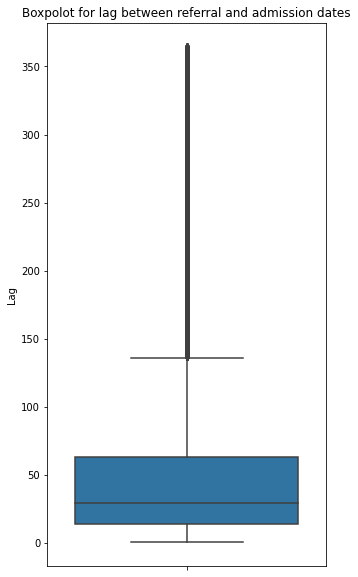

In [27]:
# Explore data outliers
plt.figure(figsize=(5, 10))
sns.boxplot (y = beds['delta'])
plt.title('Boxpolot for lag between referral and admission dates')
plt.ylabel('Lag')
plt.show()


Outliers detected but not deleted since customer is interested in all data.

In [28]:
print('Cleared data contains referrals from', beds['referral_date'].min(), 'to', beds['referral_date'].max())

Cleared data contains referrals from 2018-01-25 00:00:00 to 2023-12-27 00:00:00


### Unique patients

In [29]:
# Count unique patients
print('Number of unique patients -', len(beds['user_id'].unique()))

Number of unique patients - 32787


### Planned/emergency factor

In [30]:
# Generate pivot table in order to analyse factor
beds_plan_pivot = beds.pivot_table(index='is_plan', values='delta', aggfunc=['count','mean','median','max'])
beds_plan_pivot.columns = ['count', 'mean','median','max']
beds_plan_pivot['mean'] = round(beds_plan_pivot['mean'])
beds_plan_pivot = beds_plan_pivot.reset_index()
beds_plan_pivot

,is_plan,count,mean,median,max
0,Плановая,57803,52.0,29,364
1,Экстренная,537,45.0,24,362


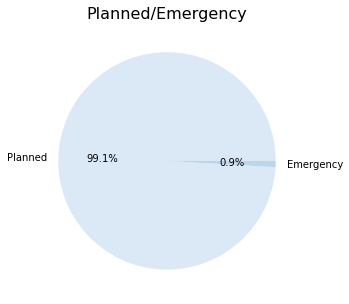

In [31]:
# Build barplot
plt.figure(figsize=(10, 5))
labels = ["Planned", "Emergency"]
beds_plan_pivot['count'].plot(kind='pie', autopct='%1.1f%%', labels=labels, colors=sns.color_palette("Blues"))
plt.title("Planned/Emergency", fontsize=16 )
plt.ylabel("")
plt.show()

In [32]:
# Transform factor data into binary
def planned (row):
    is_plan =  row['is_plan']

    if is_plan == "Плановая":
        return 1
    else:
        return 0


In [33]:
# Create column for result
beds['is_plan_num'] = beds.apply(planned, axis=1)

In [34]:
# Calculate point-biserial correlation
st.pointbiserialr(beds['is_plan_num'], beds['delta'])

PointbiserialrResult(correlation=0.011569698997852162, pvalue=0.005197343350157813)

**Intermediate total:**
 - The vast majority of data is for planned hospitalization, since almost all logs for emergency hospitalization do not have a referral date.
 - For logs with referral date no correlation between planned/emergency factor and lag between referral and admission dates detected.

### Region factor

In [35]:
# Generate pivot table in order to analyse factor
beds_region_delta_pivot = beds.pivot_table(index='region', values='delta', aggfunc=['mean','median'])
beds_region_delta_pivot.columns = ['mean','median']
beds_region_delta_pivot['mean'] = round(beds_region_delta_pivot['mean'])

# Generate pivot table in order to analyse number of patients among regions
beds_region_user_pivot = beds.pivot_table(index='region', values='user_id', aggfunc=['count','nunique'])
beds_region_user_pivot.columns = ['count','nunique']

In [36]:

regions_analysis = pd.concat([beds_region_delta_pivot, beds_region_user_pivot],
                             axis=1, join='inner').sort_values(by='count', ascending=False)
regions_analysis

,mean,median,count,nunique
region,,,,
Ленинградская обл.,44.0,26.0,8382,4604
Новгородская обл.,51.0,31.0,3276,1750
Вологодская обл.,65.0,40.0,2221,1015
Псковская обл.,58.0,35.0,2186,1128
Карелия,55.0,38.0,1936,1090
...,...,...,...,...
Калужская обл.,59.0,22.0,9,4
Еврейская АО,57.0,63.0,5,3
Дальнее зарубежье,11.0,11.0,2,2


In [37]:
regions_analysis['count'].describe()

count      90.000000
mean      380.833333
std      1009.175158
min         1.000000
25%        50.250000
50%       107.000000
75%       256.250000
max      8382.000000
Name: count, dtype: float64

In [38]:
# Calculate 10th percentile
regions_10_percentile = round(np.percentile (regions_analysis['count'], 10))
print('For not more than 10 % of regions number of patients is less than', regions_10_percentile)


For not more than 10 % of regions number of patients is less than 31


In [39]:
# Cut out logs for those regions
regions_analysis_filtered = regions_analysis.reset_index().query('count >= @regions_10_percentile')
regions_filtered = regions_analysis_filtered['region'].unique()
beds = beds.query('region in @regions_filtered')

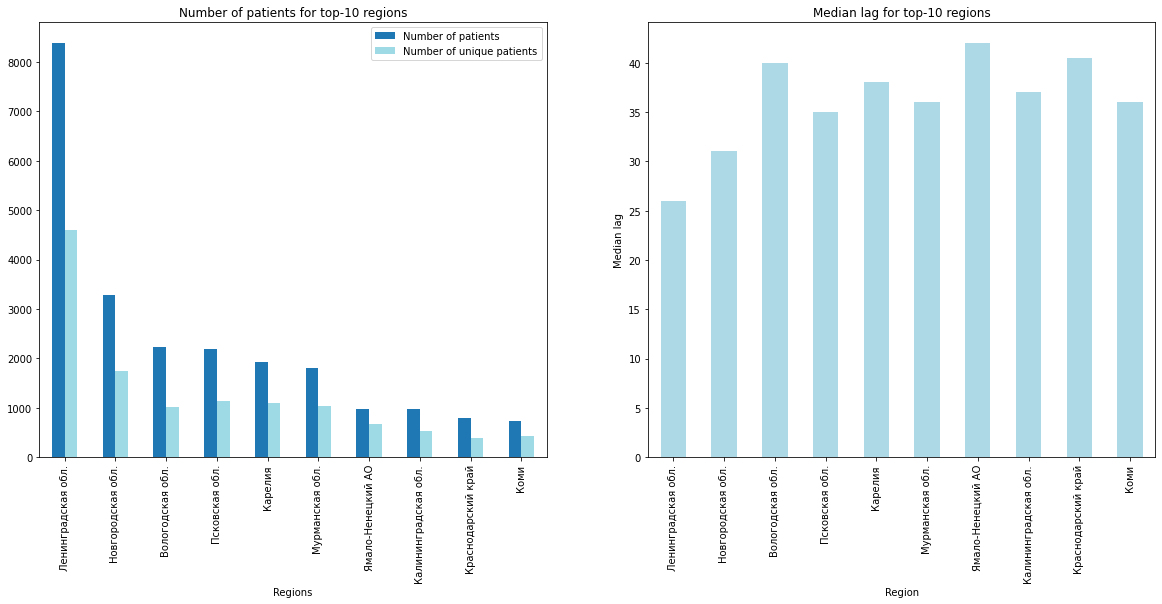

In [40]:
# Build plots for top-10 regions
regions_analysis_top_c = regions_analysis[['count', 'nunique']].sort_values(by='count', ascending=False).head(10)
regions_analysis_top_m = regions_analysis[['median', 'count']].sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(20, 8))
regions_analysis_top_c[['count', 'nunique']].plot(kind='bar', ax=plt.subplot(1, 2, 1), colormap = 'tab20')
plt.title("Number of patients for top-10 regions")
plt.legend(["Number of patients", "Number of unique patients"])
plt.xlabel('Regions')

regions_analysis_top_m.plot(y='median' , kind='bar', figsize=(15, 5), xlabel="Region", ylabel="Median lag",
                          color="lightblue", legend=False, subplots=True, ax=plt.subplot(1, 2, 2))

plt.title("Median lag for top-10 regions")
plt.show()


**Intermediate total:**
 - The vast majority of data is for region "Ленинградская область".
 - Top-6 regions by number of patients are from regions that are geographically close to the Medical center.
 - Median lag between referral and admission dates for"Ленинградская область" region is lower, however it does not seem to be fair for other geographically close to the Medical center regions.

Hypothesis on equality of means for lags between referral and admission dates for "Ленинградская область" region and other regions should be tested.

### Billing party factor

In [41]:
# Generate pivot table in order to analyse factor
beds_fin_delta_pivot = beds.pivot_table(index='fin_source', values='delta', aggfunc=['mean','median'])
beds_fin_delta_pivot.columns = ['mean','median']
beds_fin_delta_pivot['mean'] = round(beds_fin_delta_pivot['mean'])

# Generate pivot table in order to analyse number of patients among billing parties
beds_fin_user_pivot = beds.pivot_table(index='fin_source', values='user_id', aggfunc=['count','nunique'])
beds_fin_user_pivot.columns = ['count','nunique']

In [42]:
# Merge tables
fin_source_analysis = pd.concat([beds_fin_delta_pivot, beds_fin_user_pivot],
                                axis=1, join='inner').sort_values(by='count', ascending=False)
fin_source_analysis

,mean,median,count,nunique
fin_source,,,,
ОМС,59.0,35.0,26725,17123
ВМП,47.0,29.0,7017,3569
Клинические апробации,37.0,22.0,293,210
ДМС,23.0,17.0,63,53
Наличный расчет,23.0,13.5,42,39
Бюджет,15.0,14.0,19,19
Клинические исследования,6.0,6.0,1,1


In [43]:
# Calculate 5th percentile
fin_source_5_percentile = round(np.percentile (regions_analysis['count'], 5))
print('For not more than 5 % of billing parties number of patients is less than', fin_source_5_percentile)

For not more than 5 % of billing parties number of patients is less than 14


In [44]:
# Cut out logs for those billing parties
fin_source_analysis_filtered =  fin_source_analysis.reset_index().query('count >= @fin_source_5_percentile')
fin_source_filtered = fin_source_analysis_filtered['fin_source'].unique()
beds = beds.query('fin_source in @fin_source_filtered')

In [45]:
# Generate pivot table in order to analyse factor
beds_fin_delta_pivot = beds.pivot_table(index='fin_source', values='delta', aggfunc=['mean','median'])
beds_fin_delta_pivot.columns = ['mean','median']
beds_fin_delta_pivot['mean'] = round(beds_fin_delta_pivot['mean'])
beds_fin_delta_pivot = beds_fin_delta_pivot.sort_values(by='median', ascending=False)

# Generate pivot table in order to analyse number of patients among billing parties
beds_fin_user_pivot = beds.pivot_table(index='fin_source', values='user_id', aggfunc=['count','nunique'])
beds_fin_user_pivot.columns = ['count','nunique']
beds_fin_user_pivot = beds_fin_user_pivot.sort_values(by='count', ascending=False)

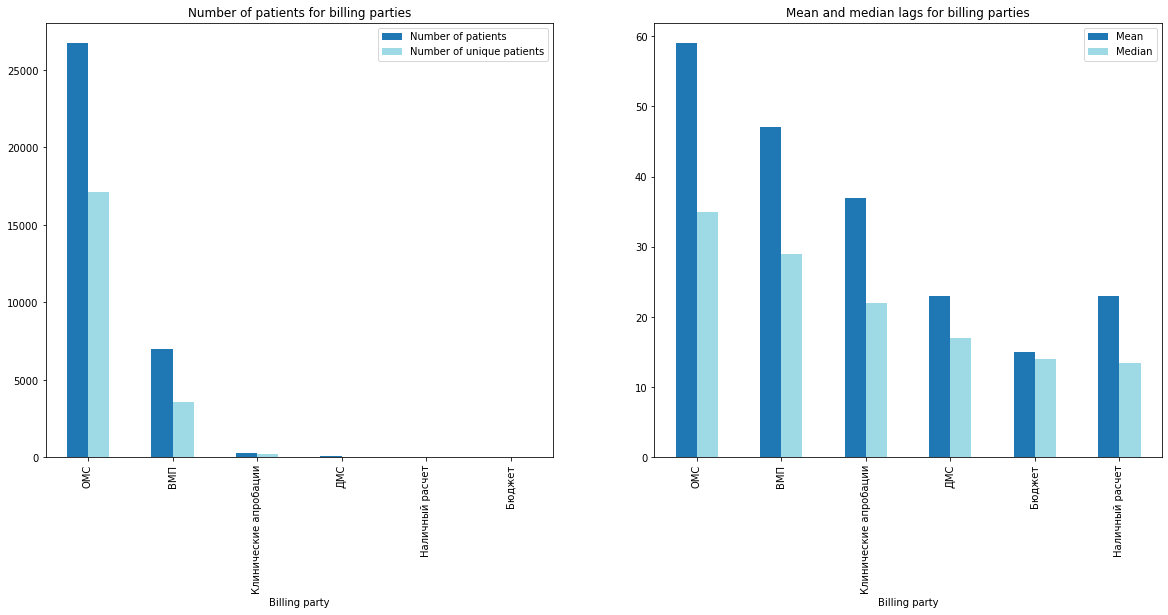

In [46]:
# Build plots for billing parties
plt.figure(figsize=(20, 8))

beds_fin_user_pivot[['count', 'nunique']].plot(kind='bar', ax=plt.subplot(1, 2, 1), colormap = 'tab20')
plt.legend(["Number of patients", "Number of unique patients"])
plt.xlabel('Billing party')
plt.title("Number of patients for billing parties")

beds_fin_delta_pivot[['mean','median']].plot(kind='bar', ax=plt.subplot(1, 2, 2), colormap = 'tab20')
plt.title("Mean and median lags for billing parties")
plt.legend(["Mean", "Median"])
plt.xlabel('Billing party')
plt.show()

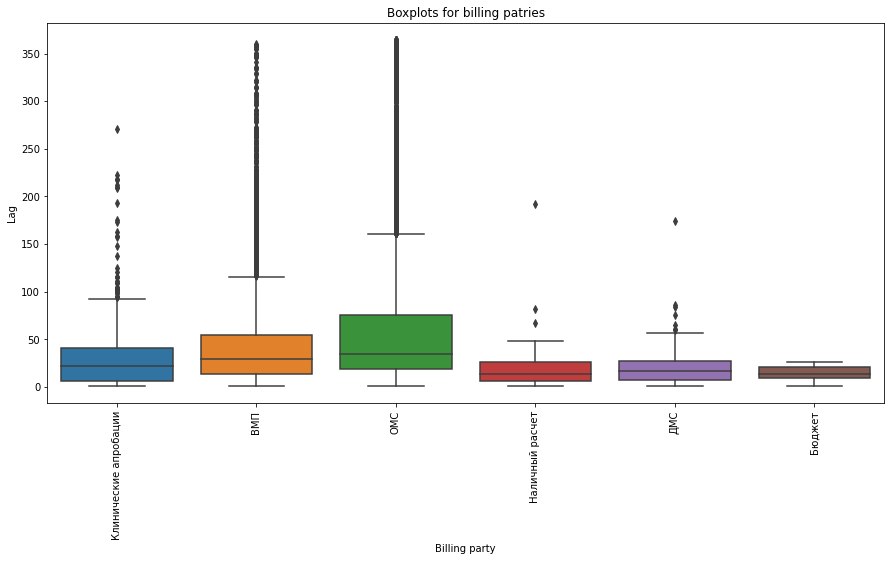

In [47]:
fig, boxplot = plt.subplots(figsize = (15,7))
sns.boxplot( x="fin_source", y="delta",  data=beds)
plt.title('Boxplots for billing patries')
plt.xlabel('Billing party')
plt.ylabel('Lag')
plt.xticks(rotation=90)
plt.show()

In [48]:
fin_source_analysis_filtered.corr()

,mean,median,count,nunique
mean,1.000000,0.981693,0.848193,0.828755
median,0.981693,1.000000,0.870612,0.849554
count,0.848193,0.870612,1.000000,0.998431
nunique,0.828755,0.849554,0.998431,1.000000


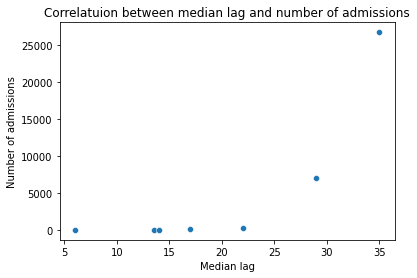

In [49]:
sns.scatterplot(data=fin_source_analysis, x="median", y="count")
plt.title('Correlatuion between median lag and number of admissions')
plt.xlabel('Median lag')
plt.ylabel('Number of admissions')
plt.show()

**Intermediate total:**
 - The vast majority of data is for the billing party "ОМС". Mean and median lag between referral and admission dates are higher for that billing party.
 - High positive correlation is detected for lag between referral and admission dates and number of unique patients.
 
Hypothesis on equality of means for lags between referral and admission dates for "ОМС" billing party and other billing parties should be tested.

### Payer factor

In [50]:
# Generate pivot table in order to analyse factor
beds_payer_delta_pivot = beds.pivot_table(index='payer', values='delta', aggfunc=['mean','median'])
beds_payer_delta_pivot.columns = ['mean','median']
beds_payer_delta_pivot['mean'] = round(beds_payer_delta_pivot['mean'])

# Generate pivot table in order to analyse number of patients among payers
beds_payer_user_pivot = beds.pivot_table(index='payer', values='user_id', aggfunc=['count','nunique'])
beds_payer_user_pivot.columns = ['count','nunique']

In [51]:
# Merge tables
payer_analysis = pd.concat([beds_payer_delta_pivot, beds_payer_user_pivot],
                             axis=1, join='inner').sort_values(by='count', ascending=False)
payer_analysis.head(5)

,mean,median,count,nunique
payer,,,,
ОМС 86 Регион,63.0,40.0,18691,12400
Фонд-Иногородние,53.0,27.0,7107,5728
ВМП,47.0,29.0,7017,3569
Клинические апробации,37.0,22.0,293,210
Терфонд ЛО,35.0,22.0,198,189


In [52]:
#Calculate 40th percentile
payer_40_percentile = round(np.percentile (payer_analysis['count'], 40))
print('Less than 40% of payers has not more than', payer_40_percentile, 'patients')

Less than 40% of payers has not more than 14 patients


In [53]:
# Cut out logs for those payers
payer_analysis_filtered =  payer_analysis.reset_index().query('count >= @payer_40_percentile')
payer_filtered = payer_analysis_filtered['payer'].unique()
beds = beds.query('payer in @payer_filtered')

In [54]:
# Generate pivot table in order to analyse factor
beds_payer_delta_pivot = beds.pivot_table(index='payer', values='delta', aggfunc=['mean','median'])
beds_payer_delta_pivot.columns = ['mean','median']
beds_payer_delta_pivot['mean'] = round(beds_payer_delta_pivot['mean'])

# Generate pivot table in order to analyse number of patients among payers
beds_payer_user_pivot = beds.pivot_table(index='payer', values='user_id', aggfunc=['count','nunique'])
beds_payer_user_pivot.columns = ['count','nunique']
beds_payer_user_pivot = beds_payer_user_pivot.sort_values(by='count', ascending=False).head(5)

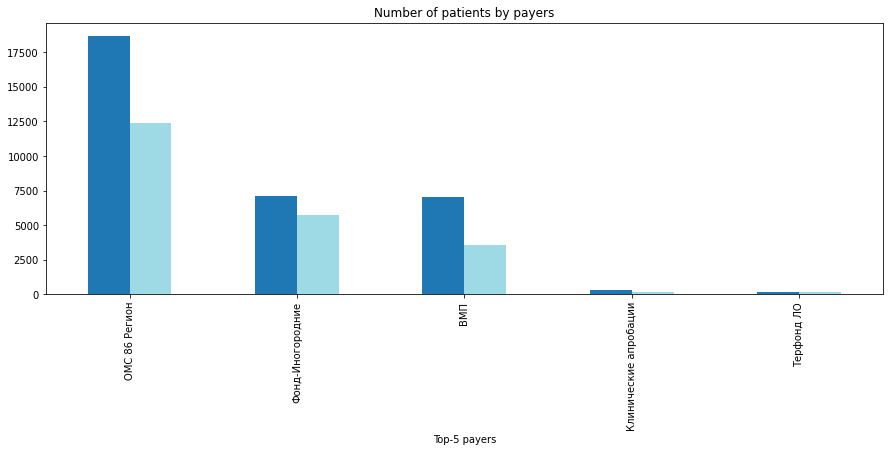

In [148]:
# Build plots for payers
beds_payer_user_pivot.plot(y=['count','nunique'], kind='bar', figsize=(15, 5), xlabel="Top-5 payers",
                           colormap = 'tab20', title="Number of patients by payers", legend=False);

In [56]:
payer_analysis.corr()

,mean,median,count,nunique
mean,1.000000,0.872602,0.575699,0.578526
median,0.872602,1.000000,0.425682,0.420755
count,0.575699,0.425682,1.000000,0.993840
nunique,0.578526,0.420755,0.993840,1.000000


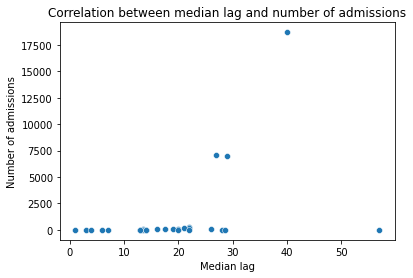

In [57]:
sns.scatterplot(data=payer_analysis, x="median", y="count")
plt.title('Correlation between median lag and number of admissions')
plt.xlabel('Median lag')
plt.ylabel('Number of admissions')
plt.show()

**Intermediate total:**
 - Factors Billing party and Payer are naturally interrelated, however correlation between mean lag and number of unique patients seems to be mild for the payer.
 
 
Hypothesis on equality of means for lags between referral and admission dates for billing parties and not for payers will be tested.

### Diagnosis factor

In [58]:
# Generate pivot table in order to analyse factor
beds_income_mkb_pivot = beds.pivot_table(index='income_mkb', values='delta', aggfunc=['mean','median'])
beds_income_mkb_pivot.columns = ['mean','median']
beds_income_mkb_pivot['mean'] = round(beds_income_mkb_pivot['mean'])

# Generate pivot table in order to analyse number of patients among diagnoses
beds_income_mkb_user_pivot = beds.pivot_table(index='income_mkb', values='user_id', aggfunc=['count','nunique'])
beds_income_mkb_user_pivot.columns = ['count','nunique']

In [59]:
# Merge tables
income_mkb_analysis = pd.concat([beds_income_mkb_pivot, beds_income_mkb_user_pivot],
                                axis=1, join='inner').sort_values(by='nunique', ascending=False)
income_mkb_analysis

,mean,median,count,nunique
income_mkb,,,,
M08.0,39.0,33.0,2870,1221
L20.8,47.0,24.0,1243,537
H52.1,51.0,29.0,671,497
J35.2,59.0,47.0,489,477
G96.8,82.0,69.0,493,458
...,...,...,...,...
M66.0,1.0,1.0,1,1
M67.4,16.0,16.0,1,1
M67.8,1.0,1.0,1,1


In [60]:
print('Correlation between number of patients with diagnosis and mean lag:', income_mkb_analysis['count'].corr(income_mkb_analysis['mean']))

Correlation between number of patients with diagnosis and mean lag: 0.037358435284254136


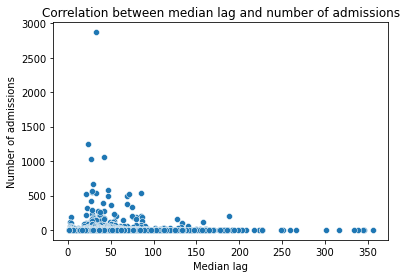

In [61]:
sns.scatterplot(data=income_mkb_analysis, x="median", y="count");
plt.title('Correlation between median lag and number of admissions')
plt.xlabel('Median lag')
plt.ylabel('Number of admissions')
plt.show()

In [62]:
income_mkb_analysis_filtered = income_mkb_analysis.query('nunique >= 100')

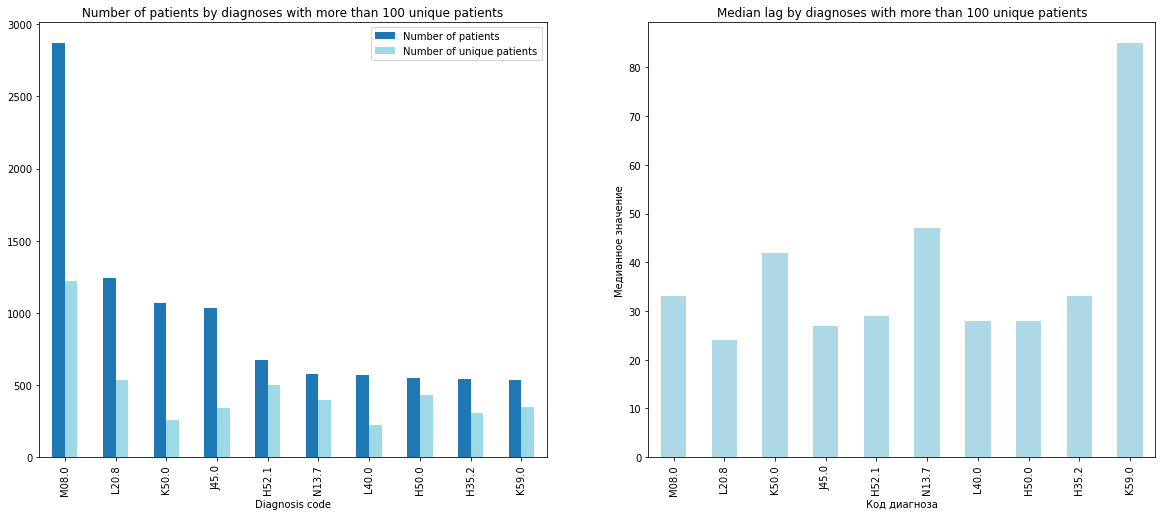

In [63]:
# Build plots for diagnoses
income_mkb_analysis_filtered_c = income_mkb_analysis_filtered[['count', 'nunique']
                                 ].sort_values(by='count', ascending=False).head(10)
income_mkb_analysis_filtered_m = income_mkb_analysis_filtered[['median', 'count']
                                 ].sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(20, 8))
income_mkb_analysis_filtered_c[['count', 'nunique']].plot(kind='bar', ax=plt.subplot(1, 2, 1), colormap = 'tab20')
plt.title("Number of patients by diagnoses with more than 100 unique patients")
plt.legend(["Number of patients", "Number of unique patients"])
plt.xlabel('Diagnosis code')

income_mkb_analysis_filtered_m.plot(y='median' , kind='bar', figsize=(15, 5), xlabel="Код диагноза", ylabel="Медианное значение",
                          color="lightblue", legend=False, subplots=True, ax=plt.subplot(1, 2, 2))

plt.title("Median lag by diagnoses with more than 100 unique patients")
plt.show()


In [64]:
print('Correlation between number of patients and mean lag:', income_mkb_analysis_filtered['count'].corr(income_mkb_analysis_filtered['mean']))

Correlation between number of patients and mean lag: -0.1151325313606687


**Intermediate total:**
 - Correlation between number of unique patients at the time of admission and mean lag between referral and admission dates is negative and weak.
 - More than 90% of diagnoses have less than 100 unique patients.
 
Hypothesis on equality of means for lags between referral and admission dates for diagnoses with more than 100 unique patients and other diagnoses should be tested.

### Department factor

In [65]:
# Generate pivot table in order to analyse factor
beds_dept_pivot = beds.pivot_table(index='dept', values='delta', aggfunc=['mean','median'])
beds_dept_pivot.columns = ['mean','median']
beds_dept_pivot['mean'] = round(beds_dept_pivot['mean'])

# Generate pivot table in order to analyse number of patients among departments
beds_dept_user_pivot = beds.pivot_table(index='dept', values='user_id', aggfunc=['count','nunique'])
beds_dept_user_pivot.columns = ['count','nunique']

In [66]:
# Merge tables
dept_analysis = pd.concat([beds_dept_pivot, beds_dept_user_pivot],
                                axis=1, join='inner').sort_values(by='median', ascending=False)
dept_analysis

,mean,median,count,nunique
dept,,,,
Хирургическое 1,101.0,75.0,1628,1215
Микрохирургическое,108.0,71.0,1551,1031
Психоневрологическое,75.0,63.0,3135,2251
Хирургическое 3,73.0,50.0,1186,809
Отоларингологическое,66.0,49.0,1829,1421
Гастроэнтерологическое дн.стац.,84.0,49.0,69,66
Гастроэнтерологическое,75.0,49.0,3295,1272
Инфекционно-диагност.,60.0,41.5,298,292
Педиатрия 1,51.0,37.0,2142,1280


In [67]:
dept_analysis.corr()

,mean,median,count,nunique
mean,1.000000,0.964640,0.393532,0.448748
median,0.964640,1.000000,0.429175,0.489633
count,0.393532,0.429175,1.000000,0.958138
nunique,0.448748,0.489633,0.958138,1.000000


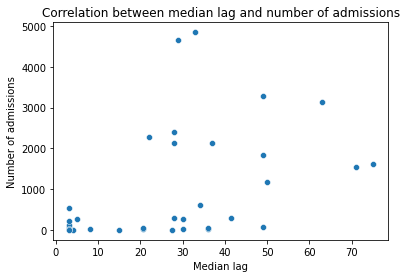

In [68]:
sns.scatterplot(data=dept_analysis, x="median", y="count")
plt.title('Correlation between median lag and number of admissions')
plt.xlabel('Median lag')
plt.ylabel('Number of admissions')
plt.show()

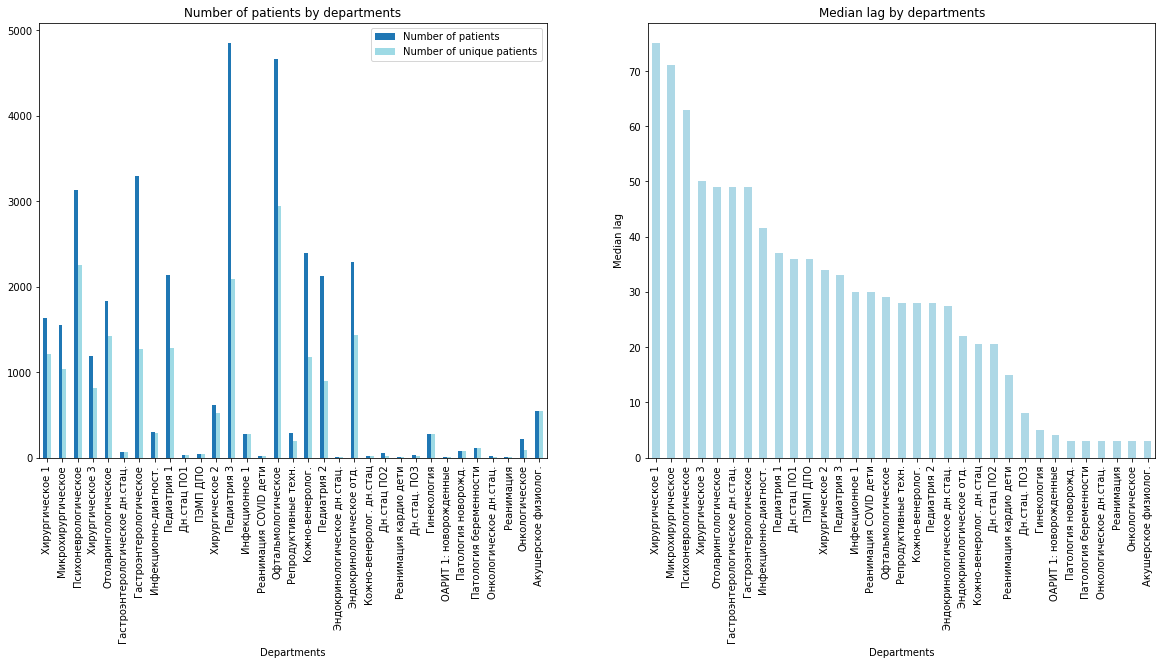

In [69]:
# Build plots for departments
plt.figure(figsize=(20, 8))

dept_analysis[['count', 'nunique']].plot(kind='bar', ax=plt.subplot(1, 2, 1), colormap = 'tab20')
plt.legend(["Number of patients", "Number of unique patients"])
plt.xlabel('Departments')
plt.title("Number of patients by departments")
plt.legend(["Number of patients", "Number of unique patients"])

dept_analysis['median'].plot(kind='bar', figsize=(15, 5), xlabel="Departments", ylabel="Median lag",
                          color="lightblue", legend=False, subplots=True, ax=plt.subplot(1, 2, 2))
plt.title("Median lag by departments")
plt.show()

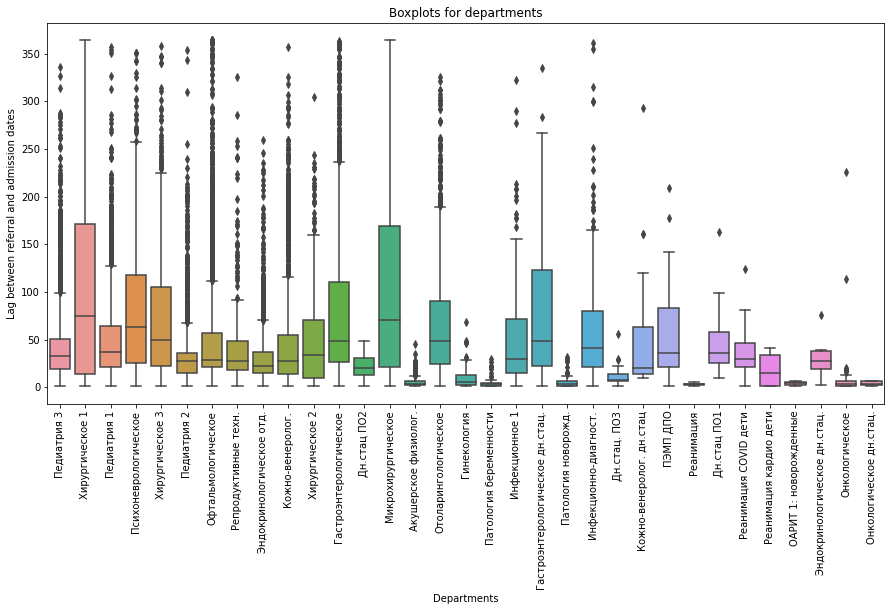

In [70]:
fig, boxplot = plt.subplots(figsize = (15,7))
sns.boxplot( x="dept", y="delta",  data=beds)
plt.title('Boxplots for departments')
plt.xlabel('Departments')
plt.ylabel('Lag between referral and admission dates')
plt.xticks(rotation=90)
plt.show()

**Intermediate total:**
 - Weak correlation between number of unique patients among departments and median lag between referral and admission dates is detected.
 
 
Hypothesis on equality of means for lags between referral and admission dates for Department "Педиатрия 3" and other departments should be tested.

### Profile factor

In [71]:
# Generate pivot table in order to analyse factor
beds_profile_pivot = beds.pivot_table(index='profile', values='delta', aggfunc=['mean','median'])
beds_profile_pivot.columns = ['mean','median']
beds_profile_pivot['mean'] = round(beds_profile_pivot['mean'])

# Generate pivot table in order to analyse number of patients among profiles
beds_profile_user_pivot = beds.pivot_table(index='profile', values='user_id', aggfunc=['count','nunique'])
beds_profile_user_pivot.columns = ['count','nunique']

In [72]:
# Merge tables
profile_analysis = pd.concat([beds_profile_pivot, beds_profile_user_pivot],
                                axis=1, join='inner').sort_values(by='median', ascending=False)
profile_analysis

,mean,median,count,nunique
profile,,,,
Сосудистой хирургии,114.0,76.0,1257,830
Гнойные хирургические,67.0,76.0,11,10
Уроандрологические,101.0,75.0,1628,1215
Психиатрические (психоневрологические),78.0,67.0,1419,1180
Проктологические,84.0,66.5,722,443
Челюстно-лицевая хирургия,98.0,64.0,162,133
Неврологические,72.0,61.0,1716,1379
Торакальной хирургии,68.0,54.0,278,240
Гастроэнтерологические,76.0,50.0,3202,1207


In [73]:
profile_analysis.corr()

,mean,median,count,nunique
mean,1.000000,0.936505,0.271903,0.330788
median,0.936505,1.000000,0.263815,0.323554
count,0.271903,0.263815,1.000000,0.950727
nunique,0.330788,0.323554,0.950727,1.000000


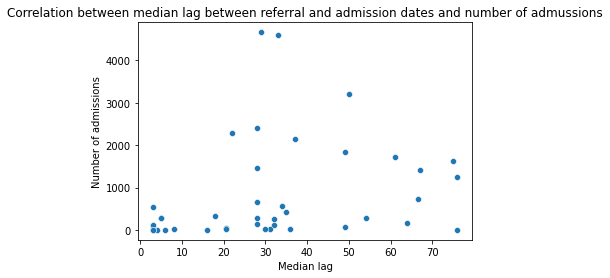

In [74]:
sns.scatterplot(data=profile_analysis, x="median", y="count")
plt.title('Correlation between median lag between referral and admission dates and number of admussions')
plt.xlabel('Median lag')
plt.ylabel('Number of admissions')
plt.show()

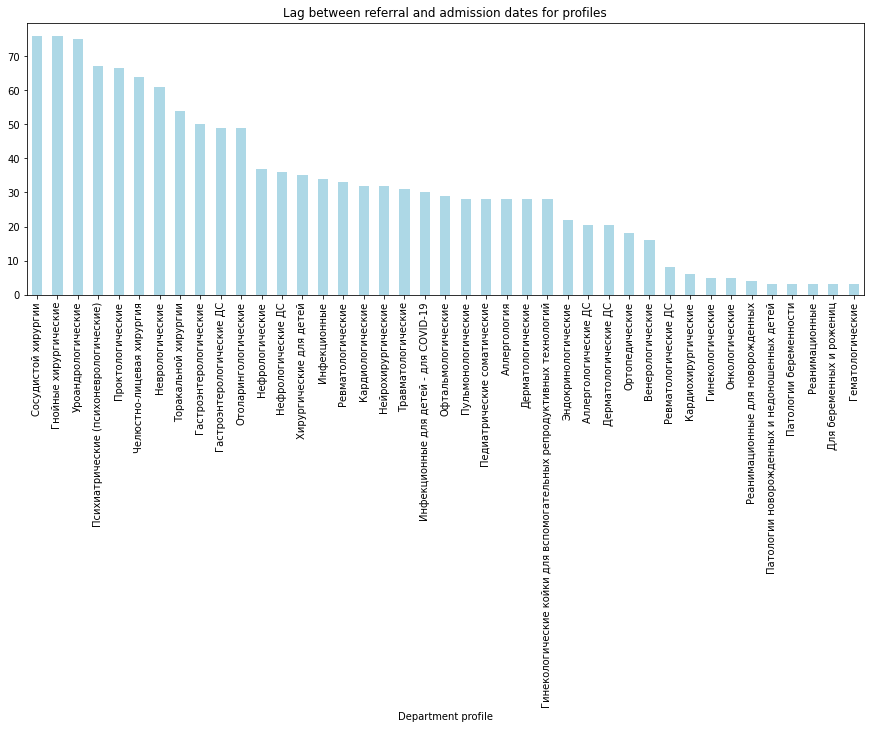

In [75]:
# Build plots for profiles
profile_analysis.plot(y='median', kind='bar', figsize=(15, 5), xlabel="Department profile",
                         color="lightblue", title="Lag between referral and admission dates for profiles", legend=False);

**Intermediate total:**
 - Weak correlation between number of unique patients among profiles and median lag between referral and admission dates is detected.
 
 
Since Profile and Department factors are naturally interrelated hypothesis on equality of means for lags between referral and admission dates for departments and not for profiles will be tested.

### Refferal month factor

In [76]:
#Add referral month column
beds['referral_month'] = beds['referral_date'].dt.month

#Add referral year column
beds['referral_year'] = beds['referral_date'].dt.year

#Add referral day column
beds['referral_day'] = beds['referral_date'].dt.day

In [77]:
# Generate pivot table in order to analyse factor
beds_referral_month_pivot = beds.pivot_table(index='referral_month', values='delta', aggfunc=['mean','median'])
beds_referral_month_pivot.columns = ['mean','median']
beds_referral_month_pivot['mean'] = round(beds_referral_month_pivot['mean'])

# Generate pivot table in order to analyse number of patients by referral months
beds_referral_month_user_pivot = beds.pivot_table(index='referral_month', values='user_id', aggfunc=['count','nunique'])
beds_referral_month_user_pivot.columns = ['count','nunique']

In [78]:
# Merge tables
beds_referral_month_analysis = pd.concat([beds_referral_month_pivot,beds_referral_month_user_pivot],
                                axis=1, join='inner')
beds_referral_month_analysis

,mean,median,count,nunique
referral_month,,,,
1,43.0,25,2568,2305
2,61.0,32,2881,2599
3,62.0,35,2989,2640
4,66.0,43,3140,2801
5,61.0,38,2830,2514
6,63.0,41,2930,2535
7,60.0,41,2924,2588
8,52.0,33,2089,1862
9,47.0,28,3000,2662


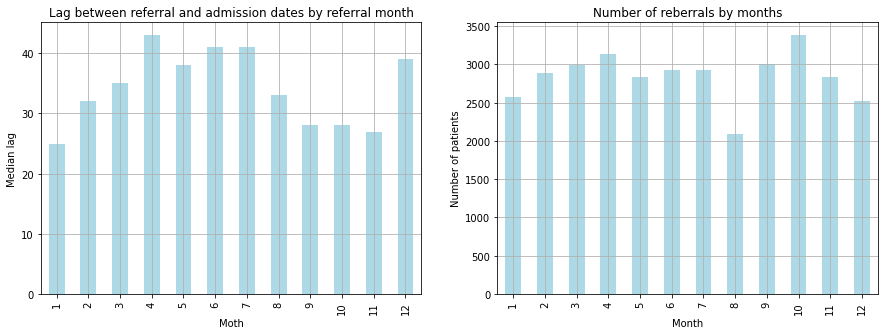

In [79]:
# Build plots for referral month
beds_referral_month_analysis.plot(y='median' , kind='bar', figsize=(15, 5), xlabel="Moth", ylabel="Median lag",
                                  color="lightblue", legend=False, subplots=True, ax=plt.subplot(1, 2, 1), grid=True)
plt.title("Lag between referral and admission dates by referral month")
beds_referral_month_analysis.plot(y='count' , kind='bar', figsize=(15, 5), xlabel="Month", ylabel="Number of patients",
                         color="lightblue", legend=False, grid=True, ax=plt.subplot(1, 2, 2))
plt.title("Number of reberrals by months")
plt.show()

In [80]:
# Generate pivot table by years
beds_filtered = beds.query('referral_year > 2018')
referral_pivot = beds_filtered.pivot_table(index ='referral_month', columns = 'referral_year', values = 'delta', aggfunc ='median')
referral_pivot

referral_year,2019,2020,2021,2022,2023
referral_month,,,,,
1,35.0,21.0,14.0,33.0,32.0
2,38.0,21.0,26.0,32.0,49.0
3,28.0,18.5,41.0,34.0,40.0
4,34.0,45.0,43.0,44.0,53.0
5,32.0,27.0,36.0,45.0,41.0
6,81.0,19.0,47.0,39.0,40.0
7,67.0,21.0,35.0,45.0,51.0
8,49.0,24.0,34.5,40.0,35.0
9,30.0,21.0,32.0,35.0,28.0


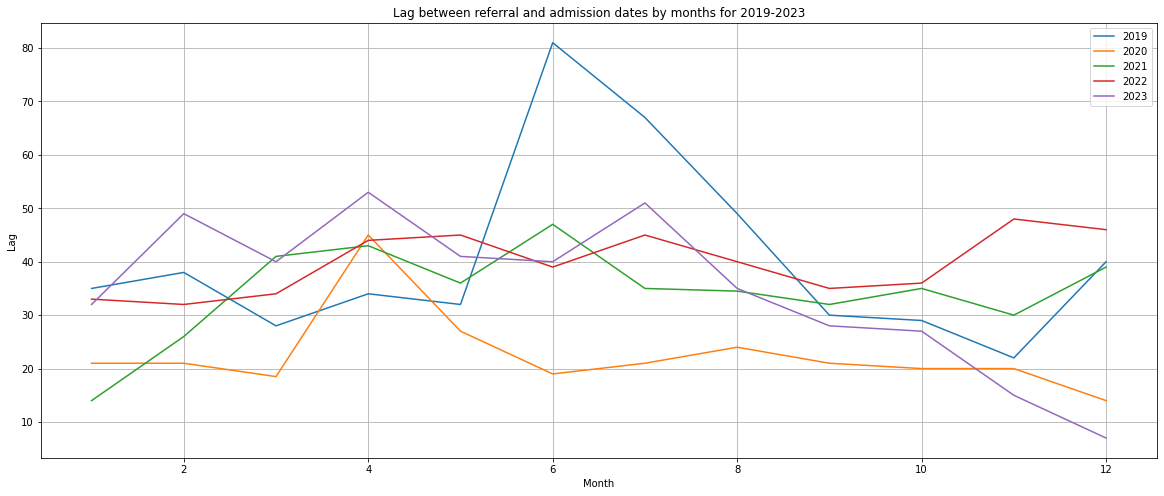

In [81]:
# Build plots for referral month by years
referral_pivot.plot(figsize = (20,8), grid=True)
plt.title('Lag between referral and admission dates by months for 2019-2023')
plt.xlabel('Month')
plt.ylabel('Lag')
plt.legend()
plt.show()

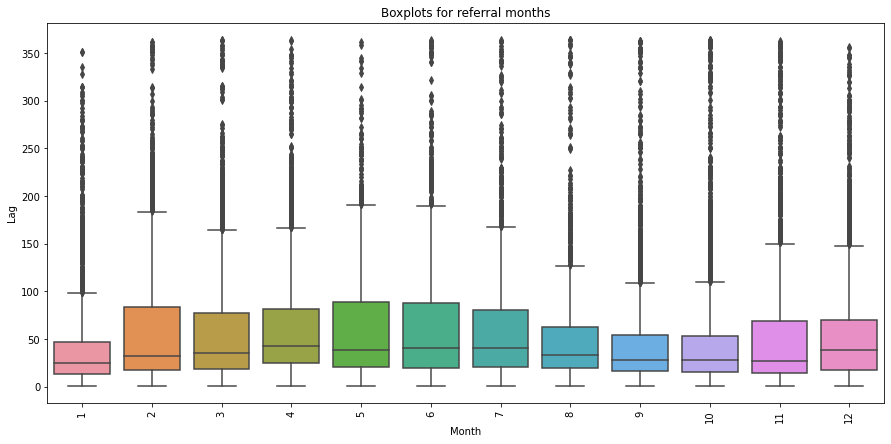

In [82]:
fig, boxplot = plt.subplots(figsize = (15,7))
sns.boxplot( x="referral_month", y="delta",  data=beds)
plt.title('Boxplots for referral months')
plt.xlabel('Month')
plt.ylabel('Lag')
plt.xticks(rotation=90)
plt.show()

**Intermediate total:**
 - Lag between referral and admission dates increases from January to April, peakes at April, then decreases till November and  increases sharply in December.
 - Meanwhile, the number of admissions increases from January to March, then decreases till August, increases in September and October and  declines in November-December.


### Admission month factor

In [83]:
# Add admission month
beds['income_month'] = beds['income_date'].dt.month

#Add admission year
beds['income_year'] = beds['income_date'].dt.year

In [84]:
# Generate pivot table in order to analyse factor
beds_income_month_pivot = beds.pivot_table(index='income_month', values='delta', aggfunc=['mean','median'])
beds_income_month_pivot.columns = ['mean','median']
beds_income_month_pivot['mean'] = round(beds_income_month_pivot['mean'])

# Generate pivot table in order to analyse number of patients by admission months
beds_income_month_user_pivot = beds.pivot_table(index='income_month', values='user_id', aggfunc=['count','nunique'])
beds_income_month_user_pivot.columns = ['count','nunique']

In [85]:
# Merge tables
beds_income_month_analysis = pd.concat([beds_income_month_pivot,beds_income_month_user_pivot],
                                axis=1, join='inner')
beds_income_month_analysis

,mean,median,count,nunique
income_month,,,,
1,55.0,35.0,2480,2240
2,50.0,27.0,2689,2412
3,52.0,29.0,2857,2518
4,47.0,31.5,2310,2078
5,53.0,36.0,2499,2223
6,59.0,36.0,3050,2636
7,53.0,35.0,2507,2145
8,63.0,42.0,2730,2328
9,71.0,45.0,3268,2896


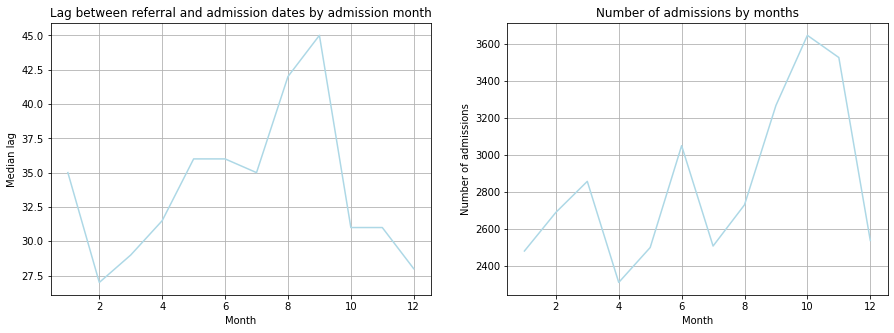

In [86]:
# Build plots for admission month
beds_income_month_analysis.plot(y='median' , kind='line', figsize=(15, 5), xlabel="Month", ylabel="Median lag",
                                  color="lightblue", legend=False, subplots=True, grid=True, ax=plt.subplot(1, 2, 1))
plt.title("Lag between referral and admission dates by admission month")
beds_income_month_analysis.plot(y='count' , kind='line', figsize=(15, 5), xlabel="Month", ylabel="Number of admissions",
                         color="lightblue", legend=False, ax=plt.subplot(1, 2, 2), grid=True)
plt.title("Number of admissions by months")
plt.show()

In [87]:
# Generate pivot table by years
income_pivot_years = beds.pivot_table(index = 'income_month', columns = 'income_year', values = 'delta', aggfunc ='median')
income_pivot_years

income_year,2019,2020,2021,2022,2023
income_month,,,,,
1,52.0,40.0,10.0,40.0,42.0
2,33.0,27.0,18.0,32.0,32.0
3,32.0,23.0,26.0,32.0,38.0
4,27.0,14.5,31.0,33.0,35.0
5,38.0,26.0,40.0,34.0,36.0
6,31.0,19.0,42.0,39.0,51.0
7,33.0,18.0,35.0,36.0,49.0
8,69.5,25.0,35.0,43.0,46.0
9,76.0,22.0,53.0,49.0,54.0


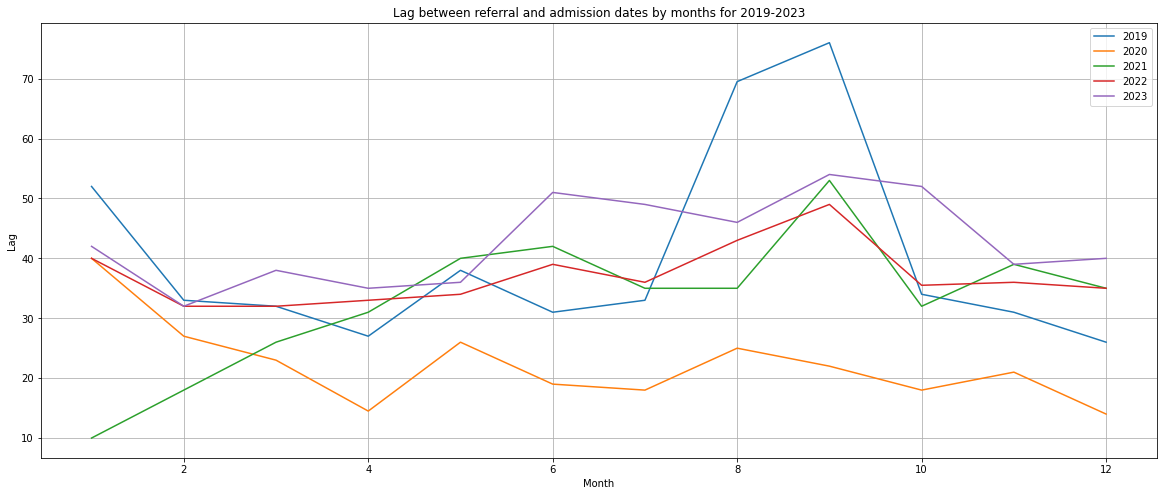

In [88]:
# Build plots for admissiom month by years
income_pivot_years.plot(figsize = (20,8), grid=True)
plt.title('Lag between referral and admission dates by months for 2019-2023')
plt.xlabel('Month')
plt.ylabel('Lag')
plt.legend()
plt.show()

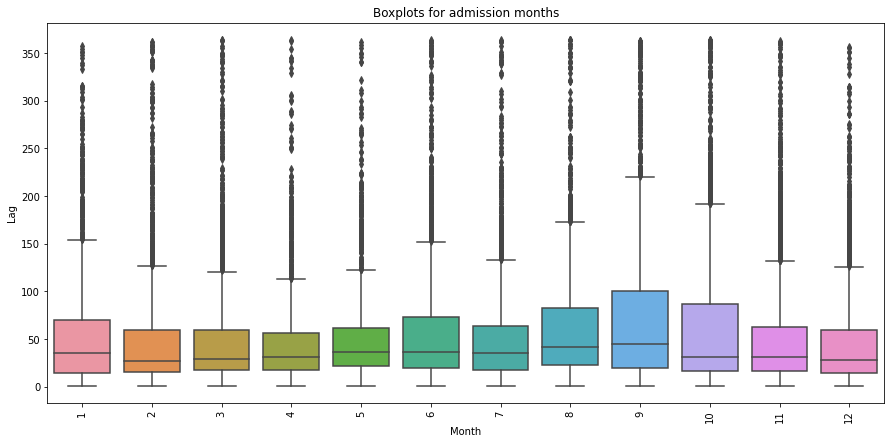

In [89]:
fig, boxplot = plt.subplots(figsize = (15,7))
sns.boxplot( x="income_month", y="delta",  data=beds)
plt.title('Boxplots for admission months')
plt.xlabel('Month')
plt.ylabel('Lag')
plt.xticks(rotation=90)
plt.show()

**Intermediate total:**
 - The vast majority of asmissions are presented in October-November, the lowest values in December-January.

## Correlation

In [90]:
# Breack data into groups by lag between referral and admission dates (number of logs in groups should be approximately equal)
beds['group_bin'] = pd.qcut(beds['delta'].rank(method='first'), 10)


# Define factors to calculate correlation
beds_corr = beds[['referral_date', 'income_date', 'region', 'payer',
                  'fin_source', 'dept', 'profile', 'is_plan', 'income_mkb', 'group_bin']]

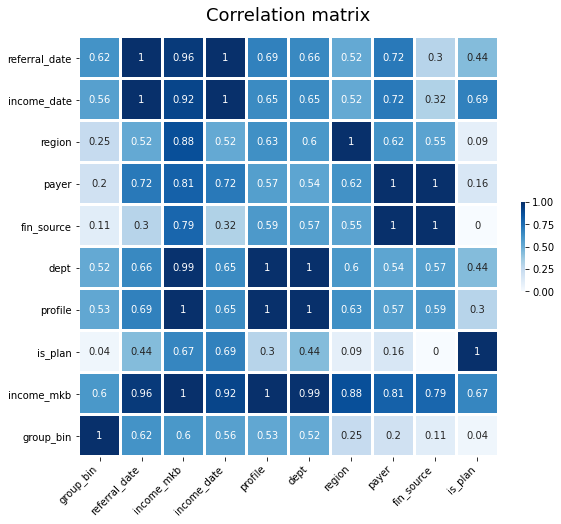

In [91]:
# Build heatmap correlation matrix
plt.figure(figsize=(8, 8))

heatmap = sns.heatmap(
    beds_corr.phik_matrix()
    .round(2)
    .sort_values("group_bin", ascending=False, axis=1),
    annot=True,
    square=True,
    cmap="Blues",
    vmax=1,
    vmin=0,
    cbar_kws={"fraction": 0.01}, # расширим палитру
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Correlation matrix", fontdict={"fontsize": 18}, pad=16)
plt.show()


**According to Chaddock scale:**
 - High positive correlation is detected between lag and:
   - referral date;
   - admission date.
 - Medium positive correlation is detected between lag and:
   - diagnosis;
   - profile;
   - department.
 - Quite weak positive correlation is detected between lag  and:
   - region;
   - payer;
   - billing party;
   - planned/emergency factor. 

## Statistical hypotheses testing

### Lag for region "Ленинградская область" and others

*Hypothesis H0: Mean lag between referral and admission dates for region "Ленинградская область" and others are equal*

*Hypothesis H1: Mean lag between referral and admission dates for region "Ленинградская область" and others are not equal*

In [92]:
beds_lo=beds.query('region == "Ленинградская обл."')
beds_other=beds.query('region != "Ленинградская обл."')

lo = beds_lo['delta']
other = beds_other['delta']

alpha = 0.05 # statistical significance level

results = st.ttest_ind(lo, other, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Discard Hypothesis H0')
else:
    print('Hypothesis H0 could not be discarded')

p-value: 2.2571910518854702e-119
Discard Hypothesis H0


**Intermediate total:**
Mean lag between referral and admission dates for region "Ленинградская область" and others are not equal.

### Lag for billing party "ОМС" and others

*Гипотеза H0: Mean lag between referral and admission dates for billing party "ОМС" and others are equal*

*Гипотеза H1: Mean lag between referral and admission dates for billing party "ОМС" and others are not equal*

In [93]:
beds_oms=beds.query('fin_source == "ОМС"')
beds_other=beds.query('fin_source != "ОМС"')

oms = beds_oms['delta']
other = beds_other['delta']

alpha = 0.05 # statistical significance level
results = st.ttest_ind(oms, other, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Discard Hypothesis H0')
else:
    print('Hypothesis H0 could not be discarded')

p-value: 1.5273493287403175e-73
Discard Hypothesis H0


**Intermediate total:**
Mean lag between referral and admission dates for billing party "ОМС" and others are not equal.

### Lag for planned/emergency factor

*Hypothesis H0: Mean lag between referral and admission dates for planned and emergency admissions are equal*

*Hypothesis H1: Mean lag between referral and admission dates for planned and emergency admissions are not equal*

In [94]:
beds_plan=beds.query('is_plan == "Плановая"')
beds_not_plan=beds.query('is_plan == "Экстренная"')

plan = beds_plan['delta']
not_plan = beds_not_plan['delta']

alpha = 0.05 # statistical significance level

results = st.ttest_ind(plan, not_plan, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Discard Hypothesis H0')
else:
    print('Hypothesis H0 could not be discarded')

p-value: 0.0011623271487356509
Discard Hypothesis H0


**Intermediate total:**
Mean lag between referral and admission dates for planned and emergency admissions are not equal.

### Lag for department ''Педиатрия 3'' and others

*Hypothesis H0: Mean lag between referral and admission dates for department "Педиатрия 3" and others are equal*

*Hypothesis H1: Mean lag between referral and admission dates for department "Педиатрия 3" and others are not equal*

In [95]:
beds_pediatrics=beds.query('dept == "Педиатрия 3"')
beds_not_pediatrics=beds.query('dept != "Педиатрия 3"')

pediatrics = beds_pediatrics['delta']
not_pediatrics = beds_not_pediatrics['delta']

alpha = 0.05 # statistical significance level

results = st.ttest_ind(pediatrics, not_pediatrics, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Discard Hypothesis H0')
else:
    print('Hypothesis H0 could not be discarded')

p-value: 2.0325695182651456e-188
Discard Hypothesis H0


**Intermediate total:**
Mean lag between referral and admission dates for department "Педиатрия 3" and others are not equal.

### Lag for diagnoses with number of patients over 100 and others

*Hypothesis H0: Mean lag between referral and admission dates for diagnoses with number of patients over 100 and others are equal*

*Hypothesis H1: Mean lag between referral and admission dates for diagnoses with number of patients over 100 and others are not equal*

In [96]:
# Sort table by number of unique patients
beds_income_mkb_user_pivot.sort_values(by='nunique', ascending=False)

# Cut data by diagnoses with more than 100 unique patients
beds_income_mkb_user_pivot = beds_income_mkb_user_pivot.query('nunique >= 100')

# List duagnoses
income_mkb_100 = beds_income_mkb_user_pivot.reset_index()
i_mkb_100=income_mkb_100['income_mkb'].tolist()


In [97]:
beds_income_mkb_100=beds.query('income_mkb in @i_mkb_100')
beds_income_mkb_other=beds.query('income_mkb not in @i_mkb_100')

mkb_100 = beds_income_mkb_100['delta']
mkb_other = beds_income_mkb_other['delta']

alpha = 0.05 # statistical significance level

results = st.ttest_ind(mkb_100, mkb_other, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Discard Hypothesis H0')
else:
    print('Hypothesis H0 could not be discarded')

p-value: 0.07788194078053774
Hypothesis H0 could not be discarded


**Intermediate total:**
Mean lag between referral and admission dates for diagnoses with number of patients over 100 and others are equal

## Conclusion

1. Data loaded.

2. Data explored and prepared:
 - log contents 179559 entries;
 - duplicated rows not detected;
 - datatype for 'referral_date', 'income_date', 'outcome_date' columns corrected;
 - gaps detected:
   - 80475 in 'referral_date' column;
   - 293 in 'user_id' column.

Detected gaps make it impossible to analyse target factors, thus rows with gaps were deleted.

 - Detected and deleted duplicates for (5877 rows) 'user_id', 'income_date', 'outcome_date' columns.
 - Detected and processed duplicates for regions.
 - Payers and Departments processed.

3. Data discovery performed:

   1) Lag between referral and admission dates is determined:
      - Data presented form 2019-01-01 to 2023-12-30
      - Referrals presented from 2000-10-15 to 2023-12-30
      - Logs for patients with referrals older than 1 year and or made later than admission date were excluded and further analysed as a part of Ad-hoc study.
      - Cleared data contents referrals from 2018-01-25 to 2023-12-27.
      - Although lag range contents outliers, it is decided not to delete them.
      - Thus, lag between referral and admission dates: mean - 51, median - 29, min - 1, max - 364.
      
   2) Number of unique patients in log - 32787.
     
   3) Planned/emergency factor:
      - The vast majority of data is for planned hospitalization, since almost all logs for emergency hospitalization do not have a referral date.
      - For logs with referral date point-biserial correlation calculated: no correlation between planned/emergency factor and lag between referral and admission dates detected.
     
   4) Region factor:
        - The vast majority of data is for region "Ленинградская область".
        - Top-6 regions by number of patients are from regions that are geographically close to the Medical center.
        - Median lag between referral and admission dates for"Ленинградская область" region is lower, however it does not seem to be fair for other geographically close to the Medical center regions.
        
   Thus median lag between referral and admission dates for"Ленинградская область" region is lower.
   
    5) Billing party factor:
         - The vast majority of data is for the billing party "ОМС". Mean and median lag between referral and admission dates are higher for that billing party.
         - High positive correlation is detected for lag between referral and admission dates and number of unique patients.
        
   Thus median lag between referral and admission dates correlates with the number of unique patients: more unique patients means higher lag, and statistically lag for billing party"ОМС" is higher.
   
     6) Payer factor
        - Factors Billing party and Payer are naturally interrelated, since correlation between mean lag and number of unique patients seems to be mild for the payer, it is decided to analyse only billing party factor.   
     
     7) Diagnosis factor:
         - Correlation between number of unique patients at the time of admission and mean lag between referral and admission dates is negative and weak.
         - More than 90% of diagnoses have less than 100 unique patients.
         - Hypothesis testing proved that there is no statistical difference in lags between referral and admission dates for diagnosis with more and less than 100 unique patients.
               
     8) Department factor:
        - Weak correlation between number of unique patients among departments and median lag between referral and admission dates is detected. 
        - Hypothesis testing proved that there is statistical difference in lags between referral and admission dates for Department "Педиатрия 3" and others. For Department "Педиатрия 3" lags are higher than other departments.
               
     9) Profile factor
         - Weak correlation between number of unique patients among profiles and median lag between referral and admission dates is detected.
         - Since Profile and Department factors are naturally interrelated it is decided to analyse only Department factor.
        
     10) Referral month factor
          - Lag between referral and admission dates increases from January to April, peakes at April, then decreases till November and  increases sharply in December.
         - Meanwhile, the number of admissions increases from January to March, then decreases till August, increases in September and October and  declines in November-December.
                  
     11) Admission month factor
         - The vast majority of admissions are presented in October-November, the lowest values in December-January.
         
4. Correlation between factors is calculated.
   According to Chaddock scale:
   - High positive correlation is detected between lag and:
     - referral date;
     - admission date.
   - Medium positive correlation is detected between lag and:
     - diagnosis;
     - profile;
     - department.
   - Quite weak positive correlation is detected between lag  and:
     - region;
     - payer;
     - billing party;
     - planned/emergency factor. 

5. According to above-stated following statistical hypotheses were tested:

   1) Mean lag between referral and admission dates for region "Ленинградская область" and others are not equal
   Lag between referral and admission dates for patients from region "Ленинградская область" is lower.

   2) Mean lag between referral and admission dates for billing party "ОМС" and others are not equal.
   Lag between referral and admission dates for the billing party "ОМС" is higher.
      
   3) Mean lag between referral and admission dates for planned and emergency admissions are not equal.
   Lag between referral and admission dates for emergency admissions is lower.
   
   4) Mean lag between referral and admission dates for department "Педиатрия 3" and others are not equal.
   Lag between referral and admission dates for department "Педиатрия 3" is lower.
      
   5) Mean lag between referral and admission dates for diagnoses with the number of patients over 100 and others are statistically equal.
   Lag between referral and admission dates for diagnoses with a number of patients over 100 is equal to less popular diagnoses.


## Ad-hoc sudy

### Analysis for referral dates older or equal to admission date

In [98]:
# Cut entries for referral dates older than admission date
beds_minus = beds_copy.query('delta < 0')
# Cut entries for referral dates equal to admission date
beds_zero = beds_copy.query('delta == 0')

#### Referral date older than admission date

In [99]:
beds_minus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 10518 to 133604
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          9 non-null      int64         
 1   referral_date  9 non-null      datetime64[ns]
 2   income_date    9 non-null      datetime64[ns]
 3   outcome_date   9 non-null      datetime64[ns]
 4   user_id        9 non-null      float64       
 5   is_num         9 non-null      int64         
 6   code           9 non-null      object        
 7   region         7 non-null      object        
 8   payer          9 non-null      object        
 9   fin_source     9 non-null      object        
 10  dept           9 non-null      object        
 11  profile        9 non-null      object        
 12  bed_days       9 non-null      float64       
 13  is_plan        9 non-null      object        
 14  income_mkb     9 non-null      object        
 15  outcome_mkb    9 n

In [100]:
# Generate pivot table in order to analyse region factor
beds_minus_region_user_pivot = beds_minus.pivot_table(index='region', values='user_id', aggfunc=['count','nunique'])
beds_minus_region_user_pivot.columns = ['count','nunique']
beds_minus_region_user_pivot.sort_values(by='count', ascending=False)

,count,nunique
region,,
Дагестан,2,2
Коми,2,2
Псковская обл.,2,2
Архангельская обл.,1,1


In [101]:
# Generate pivot table in order to analyse billing party factor
beds_minus_fin_user_pivot = beds_minus.pivot_table(index='fin_source', values='user_id', aggfunc=['count','nunique'])
beds_minus_fin_user_pivot.columns = ['count','nunique']
beds_minus_fin_user_pivot.sort_values(by='count', ascending=False)


,count,nunique
fin_source,,
ВМП,6,6
ОМС,3,3


In [102]:
# Generate pivot table in order to analyse planned/emergency factor
beds_minus_is_plan_pivot = beds_minus.pivot_table(index='is_plan', values='user_id', aggfunc=['count','nunique'])
beds_minus_is_plan_pivot.columns = ['count','nunique']
beds_minus_is_plan_pivot.sort_values(by='count', ascending=False)


,count,nunique
is_plan,,
Плановая,8,8
Экстренная,1,1


In [103]:
beds_minus['delta'].describe()

count     9.000000
mean     -4.555556
std       8.819171
min     -28.000000
25%      -2.000000
50%      -2.000000
75%      -1.000000
max      -1.000000
Name: delta, dtype: float64

**Intermediate total:**
 - identified 9 cases from 1 to 28 days;
 - regions: Дагестан, Коми, Псковская и Архангельская области;
 - 1 emergency and 8 planned admissions.
 - 6 payed by "ВМП", 3 by "ОМС".
 
 

#### Referral dates equal to admission date

In [104]:
beds_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28737 entries, 1 to 179556
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          28737 non-null  int64         
 1   referral_date  28737 non-null  datetime64[ns]
 2   income_date    28737 non-null  datetime64[ns]
 3   outcome_date   28734 non-null  datetime64[ns]
 4   user_id        28737 non-null  float64       
 5   is_num         28737 non-null  int64         
 6   code           28737 non-null  object        
 7   region         15128 non-null  object        
 8   payer          28737 non-null  object        
 9   fin_source     28737 non-null  object        
 10  dept           28737 non-null  object        
 11  profile        28737 non-null  object        
 12  bed_days       28734 non-null  float64       
 13  is_plan        28737 non-null  object        
 14  income_mkb     28736 non-null  object        
 15  outcome_mkb    287

In [105]:
# Generate pivot table in order to analyse region factor
beds_zero_region_user_pivot = beds_zero.pivot_table(index='region', values='user_id', aggfunc=['count','nunique'])
beds_zero_region_user_pivot.columns = ['count','nunique']
beds_zero_region_user_pivot = beds_zero_region_user_pivot.sort_values(by='count', ascending=False).head(10)
beds_zero_region_user_pivot

,count,nunique
region,,
Ленинградская обл.,4923,3312
Новгородская обл.,1100,712
Псковская обл.,738,492
Вологодская обл.,698,412
Дагестан,563,379
Чечня,498,356
Мурманская обл.,467,307
Калининградская обл.,455,279
Карелия,439,304


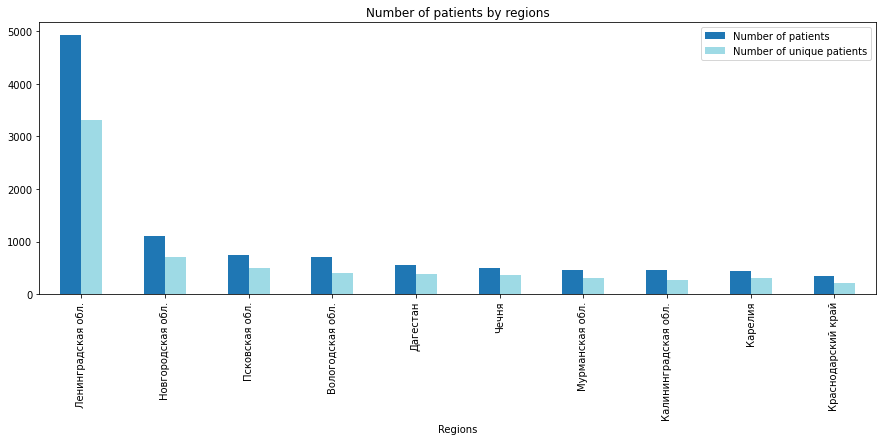

In [107]:
# Build plot
beds_zero_region_user = beds_zero_region_user_pivot.sort_values(by='count', ascending=False).reset_index()

beds_zero_region_user[['count', 'nunique']].plot(kind='bar', colormap = 'tab20', figsize=(15, 5))
plt.title("Number of patients by regions")
plt.legend(["Number of patients", "Number of unique patients"])
plt.xlabel('Regions')
plt.xticks(np.arange(len(beds_zero_region_user)), beds_zero_region_user['region'])
plt.show()

In [108]:
# Generate pivot table in order to analyse billing party factor
beds_zero_fin_user_pivot = beds_zero.pivot_table(index='fin_source', values='user_id', aggfunc=['count','nunique'])
beds_zero_fin_user_pivot.columns = ['count','nunique']
beds_zero_fin_user_pivot.sort_values(by='count', ascending=False)

,count,nunique
fin_source,,
ОМС,21164,16091
ВМП,6384,3913
Клинические апробации,963,766
Наличный расчет,182,181
ДМС,29,28
Клинические исследования,11,4
Бюджет,4,4


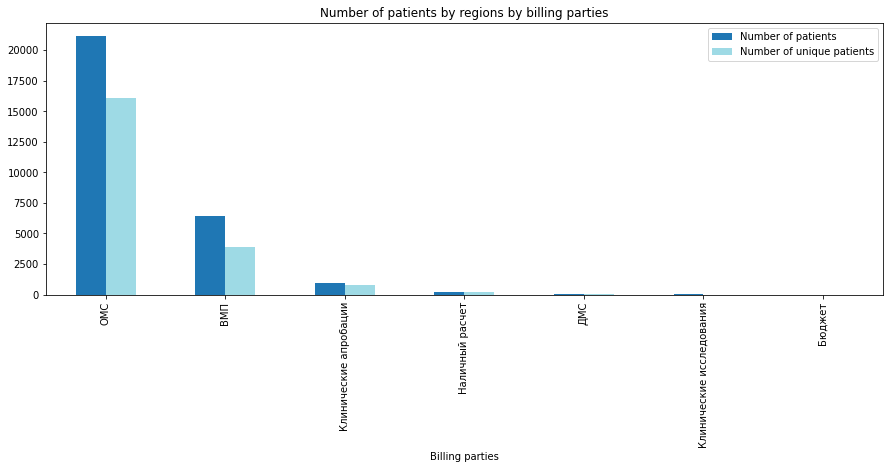

In [109]:
# Build plot
beds_zero_fin_user = beds_zero_fin_user_pivot.sort_values(by='count', ascending=False).reset_index()

beds_zero_fin_user[['count', 'nunique']].plot(kind='bar', colormap = 'tab20', figsize=(15, 5))
plt.title("Number of patients by regions by billing parties")
plt.legend(["Number of patients", "Number of unique patients"])
plt.xlabel('Billing parties')
plt.xticks(np.arange(len(beds_zero_fin_user)), beds_zero_fin_user['fin_source'])
plt.show()

In [110]:
# Generate pivot table in order to analyse planned/emergency factor
beds_zero_is_plan_pivot = beds_zero.pivot_table(index='is_plan', values='user_id', aggfunc=['count','nunique'])
beds_zero_is_plan_pivot.columns = ['count','nunique']
beds_zero_is_plan_pivot.sort_values(by='count', ascending=False)

,count,nunique
is_plan,,
Плановая,28478,19281
Экстренная,259,236


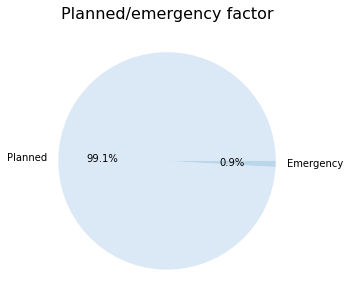

In [111]:
# Build plot
plt.figure(figsize=(10, 5))
labels = ["Planned", "Emergency"]
beds_zero_is_plan_pivot['count'].plot(kind='pie', autopct='%1.1f%%', labels=labels, colors=sns.color_palette("Blues"))
plt.title("Planned/emergency factor", fontsize=16 )
plt.ylabel("")
plt.show()


In [112]:
# Generate pivot table in order to analyse department factor
beds_zero_dept_pivot = beds_zero.pivot_table(index='dept', values='user_id', aggfunc=['count','nunique'])
beds_zero_dept_pivot.columns = ['count','nunique']
beds_zero_dept_pivot.sort_values(by='count', ascending=False).head(10)

,count,nunique
dept,,
Педиатрия 3,3237,1310
Хирургическое 1,3212,2469
Кожно-венеролог.,2894,1513
Хирургическое 2,2008,1496
Гинекология,1926,1874
Офтальмологическое,1826,1555
Отоларингологическое,1421,1273
Патология новорожд.,1329,1057
Акушерское физиолог.,1269,1263


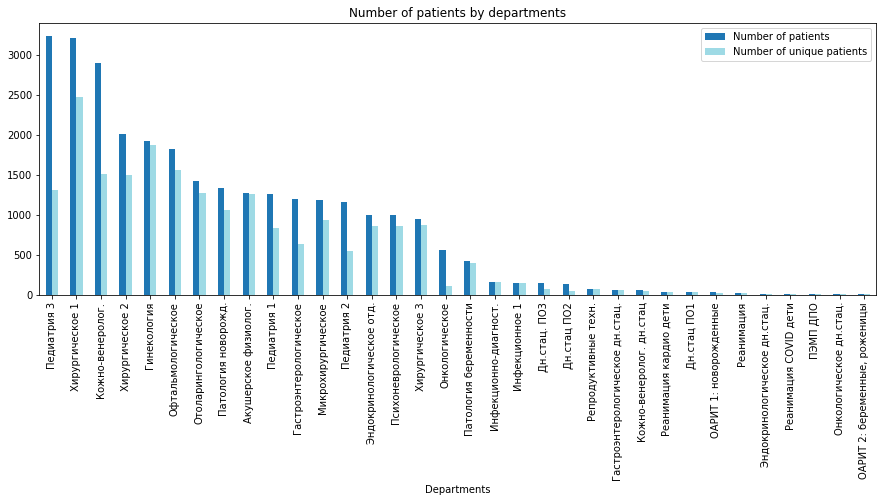

In [113]:
# Build plot
beds_zero_dept = beds_zero_dept_pivot.sort_values(by='count', ascending=False).reset_index()

beds_zero_dept[['count', 'nunique']].plot(kind='bar', colormap = 'tab20', figsize=(15, 5))
plt.title("Number of patients by departments")
plt.legend(["Number of patients", "Number of unique patients"])
plt.xlabel('Departments')
plt.xticks(np.arange(len(beds_zero_dept)), beds_zero_dept['dept'])
plt.show()


**Выводы:**
 - 28737 entries detected.
 - The vast majority of patients are from region "Ленинградская область".
 - 99% admissions are planned;
 - Most popular departments: "Педиатрия 3", "Хирургичесткое 1" и "Кожно-венерологическое".

### Duration of hospitalization

In [114]:
beds_new = pd.read_sql('SELECT * FROM beds;', con=beds_connection)

In [115]:
beds_new['bed_days'].describe()

count    179254.000000
mean          8.931081
std           9.346229
min           1.000000
25%           4.000000
50%           7.000000
75%          12.000000
max         427.000000
Name: bed_days, dtype: float64

Min - 1, max - 427.

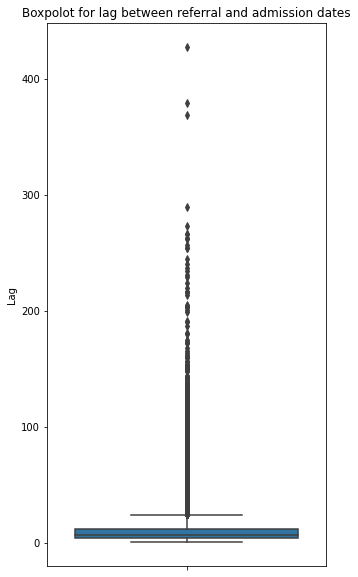

In [116]:
# Explore data outliers
plt.figure(figsize=(5, 10))
sns.boxplot (y = beds_new['bed_days'])
plt.title('Boxpolot for lag between referral and admission dates')
plt.ylabel('Lag')
plt.show()


In [117]:
# calculate 95 percentile
beds_copy_new = beds_new.dropna(subset=['bed_days'])
beds_copy_days_percentile = round(np.percentile (beds_copy_new.bed_days, 95))
print(beds_copy_days_percentile)

23


Less than 5 percent of hospitalizations last more than 23 days

In [118]:
# Cut logs for hospitalizations that last more than 23 days
beds_new_days_filtered = beds_new.query('bed_days <= @beds_copy_days_percentile')

In [119]:
beds_new_days_filtered['bed_days'].describe()

count    171097.000000
mean          7.593587
std           5.248874
min           1.000000
25%           4.000000
50%           7.000000
75%          11.000000
max          23.000000
Name: bed_days, dtype: float64

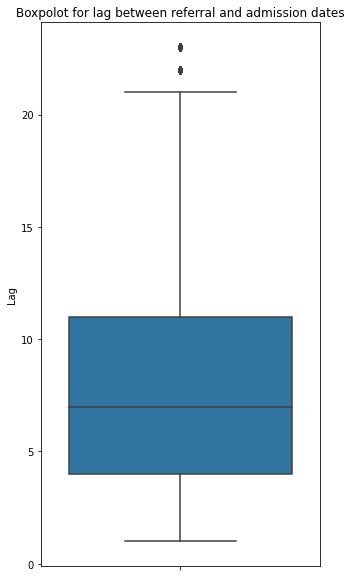

In [120]:
# Explore data outliers for cleared data
plt.figure(figsize=(5, 10))
sns.boxplot (y = beds_new_days_filtered['bed_days'])
plt.title('Boxpolot for lag between referral and admission dates')
plt.ylabel('Lag')
plt.show()


Outliers excluded.

interval columns not set, guessing: ['bed_days']


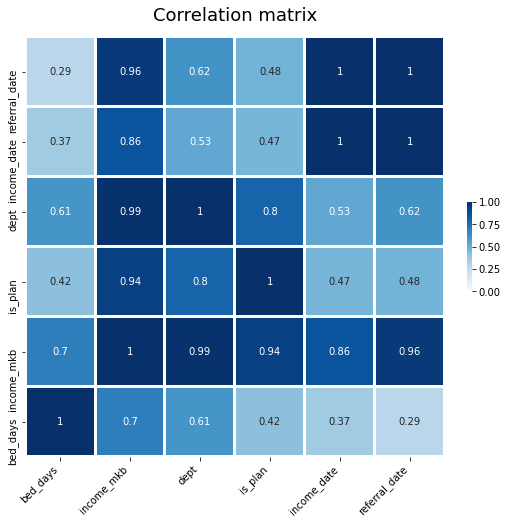

In [121]:
# Build heatmap correlation matrix

bed_days_corr = beds_new_days_filtered[['referral_date', 'income_date', 'dept', 'is_plan', 'income_mkb','bed_days']]

plt.figure(figsize=(8, 8))

heatmap = sns.heatmap(
    bed_days_corr.phik_matrix()
    .round(2)
    .sort_values("bed_days", ascending=False, axis=1),
    annot=True,
    square=True,
    cmap="Blues",
    vmax=1,
    vmin=0,
    cbar_kws={"fraction": 0.01},
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Correlation matrix", fontdict={"fontsize": 18}, pad=16)
plt.show()

**According to Chaddock scale:**
 - High positive correlation is detected between lag and  diagnosis.
 - Medium positive correlation is detected between lag and department.
 - Quite weak positive correlation is detected between lag  and:
   - admission date;
   - referral date.

### Diagnosis change from admission to discharge

In [122]:
# Diagnosis data load
mkb = pd.read_excel('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/2FLOWklSV5zhQw')

In [123]:
for col in ['referral_date', 'income_date', 'outcome_date']:
    beds_new[col] = pd.to_datetime( beds_new[col], dayfirst=True)

In [124]:
# Merge tables
mkb_names= mkb[['mkb_cod','mkb_name']]
mkb_names['income_mkb'] = mkb['mkb_cod']
beds_diagnosis = beds_new.merge(mkb_names, on='income_mkb')
beds_diagnosis.rename(columns = {'mkb_name':'income_name'}, inplace = True )
beds_diagnosis.drop(['mkb_cod'], axis= 1 , inplace= True )
mkb_names['outcome_mkb'] = mkb['mkb_cod']
beds_diagnosis = beds_diagnosis.merge(mkb_names, on='outcome_mkb')
beds_diagnosis.rename(columns = {'mkb_name':'outcome_name', 'income_mkb_x':'income_mkb' }, inplace = True )
beds_diagnosis.drop(['mkb_cod', 'income_mkb_y'], axis= 1 , inplace= True )

In [125]:
# Add table with admission month
beds_diagnosis['income_month'] = beds_diagnosis['income_date'].dt.month

# Add table with admission year
beds_diagnosis['income_year'] = beds_diagnosis['income_date'].dt.year

In [126]:
# Define if diagnosis is changed
conditions = [beds_diagnosis['income_name'] == beds_diagnosis['outcome_name'],
              beds_diagnosis['income_name'] != beds_diagnosis['outcome_name']]
choices = [0, 1]
beds_diagnosis['changed'] = np.select (conditions, choices, default='Tie')

In [127]:
# Generate pivot table in order to analyse factor
beds_diagnosis_pivot = beds_diagnosis.pivot_table(index ='changed', values = 'index', aggfunc = 'count')
beds_diagnosis_pivot['share'] = round(beds_diagnosis_pivot['index']/(beds_diagnosis_pivot['index'].sum())*100, 1)
beds_diagnosis_pivot = beds_diagnosis_pivot.rename(columns = {'index':'count'})
beds_diagnosis_pivot

,count,share
changed,,
0,99624,57.3
1,74328,42.7


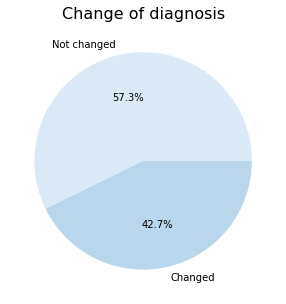

In [128]:
# Build plot
plt.figure(figsize=(10, 5))
labels = ["Not changed", "Changed"]
beds_diagnosis_pivot['count'].plot(kind='pie', autopct='%1.1f%%', labels=labels, colors=sns.color_palette("Blues"))
plt.title("Change of diagnosis", fontsize=16 )
plt.ylabel("")
plt.show()

In [129]:
# Generate pivot table in order to analyze factor
dept_diagnosis_pivot = beds_diagnosis.pivot_table (index = 'dept', columns = 'changed', values = 'index', aggfunc = 'count')
dept_diagnosis_pivot.columns = ['not_changed', 'changed']
dept_diagnosis_pivot['share_not_changed'] = round(dept_diagnosis_pivot['not_changed']/(dept_diagnosis_pivot['not_changed']+dept_diagnosis_pivot['changed'])*100, 1)
dept_diagnosis_pivot['share_changed'] = round(dept_diagnosis_pivot['changed']/(dept_diagnosis_pivot['not_changed']+dept_diagnosis_pivot['changed'])*100, 1)
dept_diagnosis_pivot = dept_diagnosis_pivot.drop (columns = ['not_changed', 'changed'])
dept_diagnosis_pivot_sorted=dept_diagnosis_pivot.sort_values(by='share_not_changed', ascending=False)
dept_diagnosis_pivot_sorted

,share_not_changed,share_changed
dept,,
ПЦ Отделение физиологии новорожденных,99.8,0.2
ПЦ Отделение вспомогательных репродуктивных технологий ДС,97.8,2.2
ПЭМП ДПО,95.3,4.7
Дневной стационар Онкогематологического отделения,92.2,7.8
Дневной стационар ПО2,89.5,10.5
Онкогематологическое отделение,79.6,20.4
Кожно-венерологическое отделение,76.8,23.2
Дневной стационар Кожно-венерологического отделения,72.5,27.5
Гинекологическое отделение перинатального центра,71.5,28.5


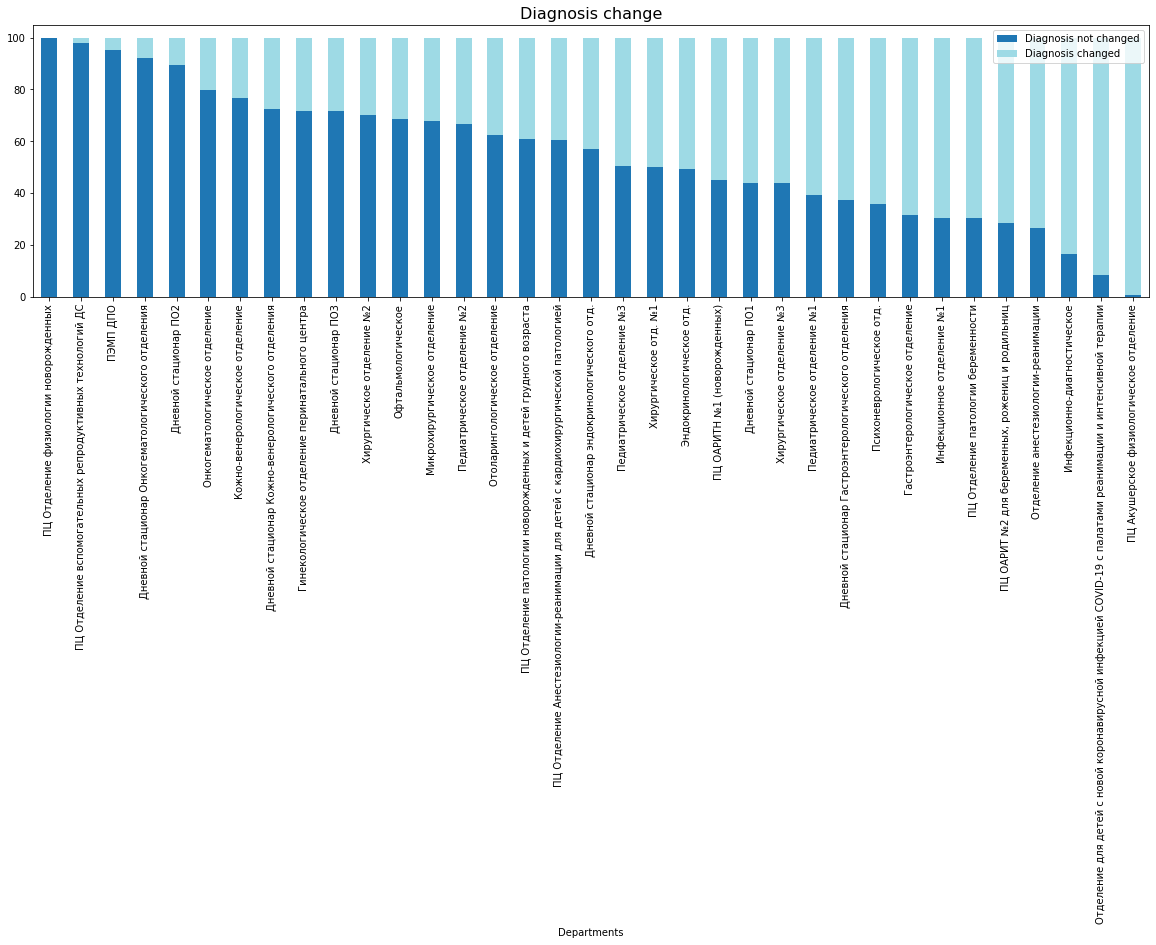

In [130]:
# Build plot
dept_diagnosis_pivot_sorted.plot(kind = 'bar', stacked = True, figsize = (20, 5), colormap = 'tab20')
plt.title("Diagnosis change", fontsize=16 )
plt.xlabel("Departments")
plt.legend(["Diagnosis not changed", "Diagnosis changed"])
plt.show()

**Total:**

Diagnosis change clearly is correlated with department.
Further analysis of department special aspects could be performed to define, whether this change is determined and proper or not.

### Seasonal factor

#### Number of admissions by months

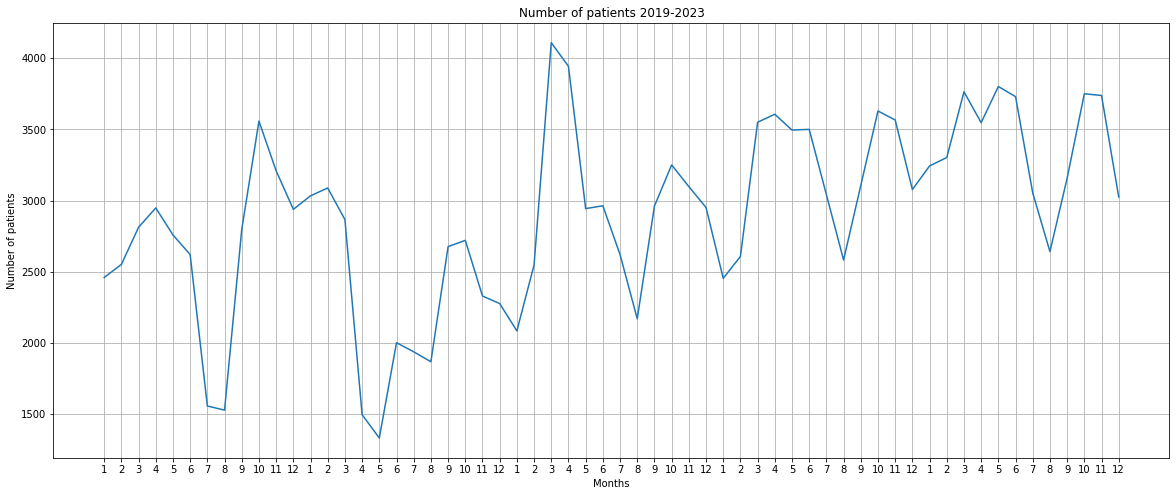

In [131]:
# Generate pivot table
income_pivot_complete = beds_diagnosis.pivot_table(index =['income_year','income_month'], values = 'index', aggfunc ='count')
income_complete = income_pivot_complete.reset_index()

# Build plot
income_complete['index'].plot(figsize = (20,8), grid=True, legend=False)
plt.title('Number of patients 2019-2023')
plt.xlabel('Months')
plt.ylabel('Number of patients')
plt.xticks(np.arange(len(income_complete)), income_complete['income_month'])
plt.show()


In [132]:
# Generate pivot table by years
income_pivot_years = beds_diagnosis.pivot_table(index = 'income_month', columns = 'income_year', values = 'index', aggfunc ='count')
income_pivot_years

income_year,2019,2020,2021,2022,2023
income_month,,,,,
1,2459,3033,2084,2453,3243
2,2551,3088,2547,2607,3302
3,2812,2866,4109,3550,3764
4,2948,1495,3943,3606,3547
5,2758,1331,2943,3495,3801
6,2620,2001,2963,3500,3730
7,1556,1937,2620,3041,3053
8,1527,1867,2169,2582,2641
9,2796,2676,2961,3106,3157


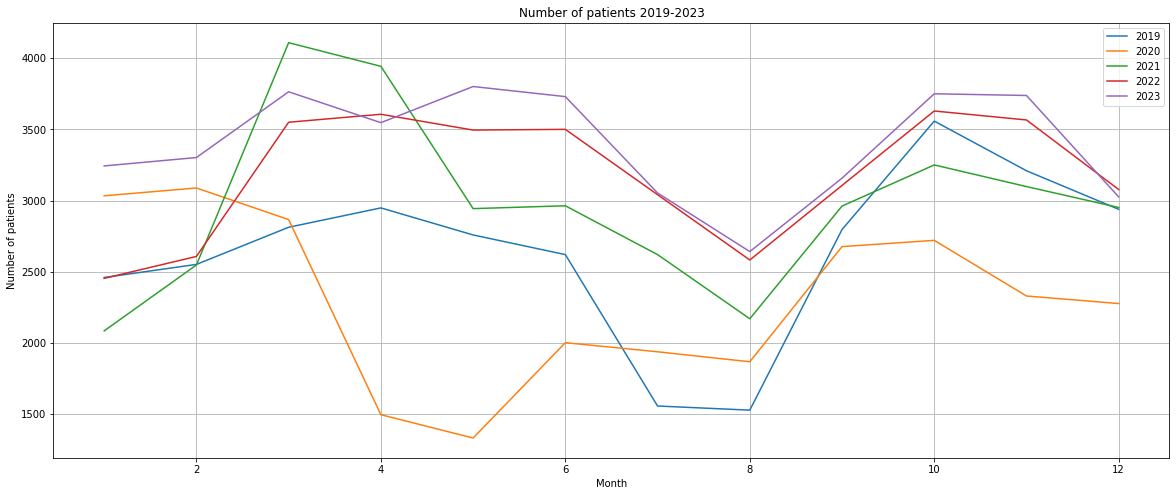

In [133]:
# Build plot
income_pivot_years.plot(figsize = (20,8), grid=True)
plt.title('Number of patients 2019-2023')
plt.xlabel('Month')
plt.ylabel('Number of patients')
plt.legend()
plt.show()

**Total:**

Data for 2020 and 2019 distorted by coronavirus. However the main trend for number of admissions through the year shows:
  - 3 peaks in March, June and October-November;
  - Lowest numbers are shown in January and December.

#### Diagnoses' groups by seasons

In [141]:
# Define function for season definition
def season (row):
    income_month =  row['income_month']
    range_1 = (12,1,2)
    range_2 = (3,4,5)
    range_3 = (6,7,8)
    range_4 = (9,10,11)

    if income_month in range_1:
        return '1 winter'
    if income_month in range_2:
        return '2 spring'
    if income_month in range_3:
        return '3 summer'
    if income_month in range_4:
        return '4 autumn'
    else:
        return 'error'

In [142]:
# Generate pivot table
beds_income_mkb_user_pivot = beds_new.pivot_table(index='income_mkb', values='user_id', aggfunc=['count','nunique'])
beds_income_mkb_user_pivot.columns = ['count','nunique']

# Sort pivot table by unique patients
beds_income_mkb_user_pivot.sort_values(by='nunique', ascending=False)

# Cut by diagnoses wuth more than 100 unique patients
beds_income_mkb_user_pivot = beds_income_mkb_user_pivot.query('nunique >= 100')

# Make a list of diagnoses
income_mkb_100 = beds_income_mkb_user_pivot.reset_index()
i_mkb_100=income_mkb_100['income_mkb'].tolist()

In [143]:
# Add column with function result
beds_income_mkb_100['income_season'] = beds_income_mkb_100.apply(season, axis=1)

In [144]:
# Define function for diagnosis group
def group (row):
    income_mkb =  row['income_mkb']

    if "E" in income_mkb:
        return 'Болезни эндокринной системы, расстройства питания и нарушения обмена веществ'
    if "G" in income_mkb:
        return 'Болезни нервной системы'
    if "H" in income_mkb:
        return 'Болезни глаза и его придаточного аппарата'
    if "J" in income_mkb:
        return 'Болезни органов дыхания'
    if "K" in income_mkb:
        return 'Болезни органов пищеварения'
    if "L" in income_mkb:
        return 'Болезни кожи и подкожной клетчатки'
    if "M" in income_mkb:
        return 'Болезни костно-мышечной системы и соединительной ткани'
    if "N" in income_mkb:
        return 'Болезни мочеполовой системы'
    if "O" in income_mkb:
        return 'Беременность, роды и послеродовой период'
    if "Q" in income_mkb:
        return 'Врожденные аномалии (пороки развития), деформации и хромосомные нарушения'
    if "Z" in income_mkb:
        return 'Факторы, влияющие на состояние здоровья населения и обращения в учреждения здравоохранения'
    else:
        return 'ошибка'

In [145]:
# Add column with function result
beds_income_mkb_100['group_mkb'] = beds_income_mkb_100.apply(group, axis=1)

In [146]:
income_pivot_season = beds_income_mkb_100.pivot_table(index = 'group_mkb', columns = 'income_season', values = 'index', aggfunc ='count')
season_diagnosis = income_pivot_season.reset_index()
season_diagnosis

income_season,group_mkb,1 winter,2 spring,3 summer,4 autumn
0,"Беременность, роды и послеродовой период",109,89,39,63
1,Болезни глаза и его придаточного аппарата,571,509,793,769
2,Болезни кожи и подкожной клетчатки,466,528,608,674
3,Болезни костно-мышечной системы и соединительной ткани,641,776,840,881
4,Болезни мочеполовой системы,407,402,454,705
5,Болезни нервной системы,395,434,487,610
6,Болезни органов дыхания,450,483,503,568
7,Болезни органов пищеварения,638,622,668,916
8,"Болезни эндокринной системы, расстройства питания и нарушения обмена веществ",224,298,345,358
9,"Врожденные аномалии (пороки развития), деформации и хромосомные нарушения",338,315,346,492


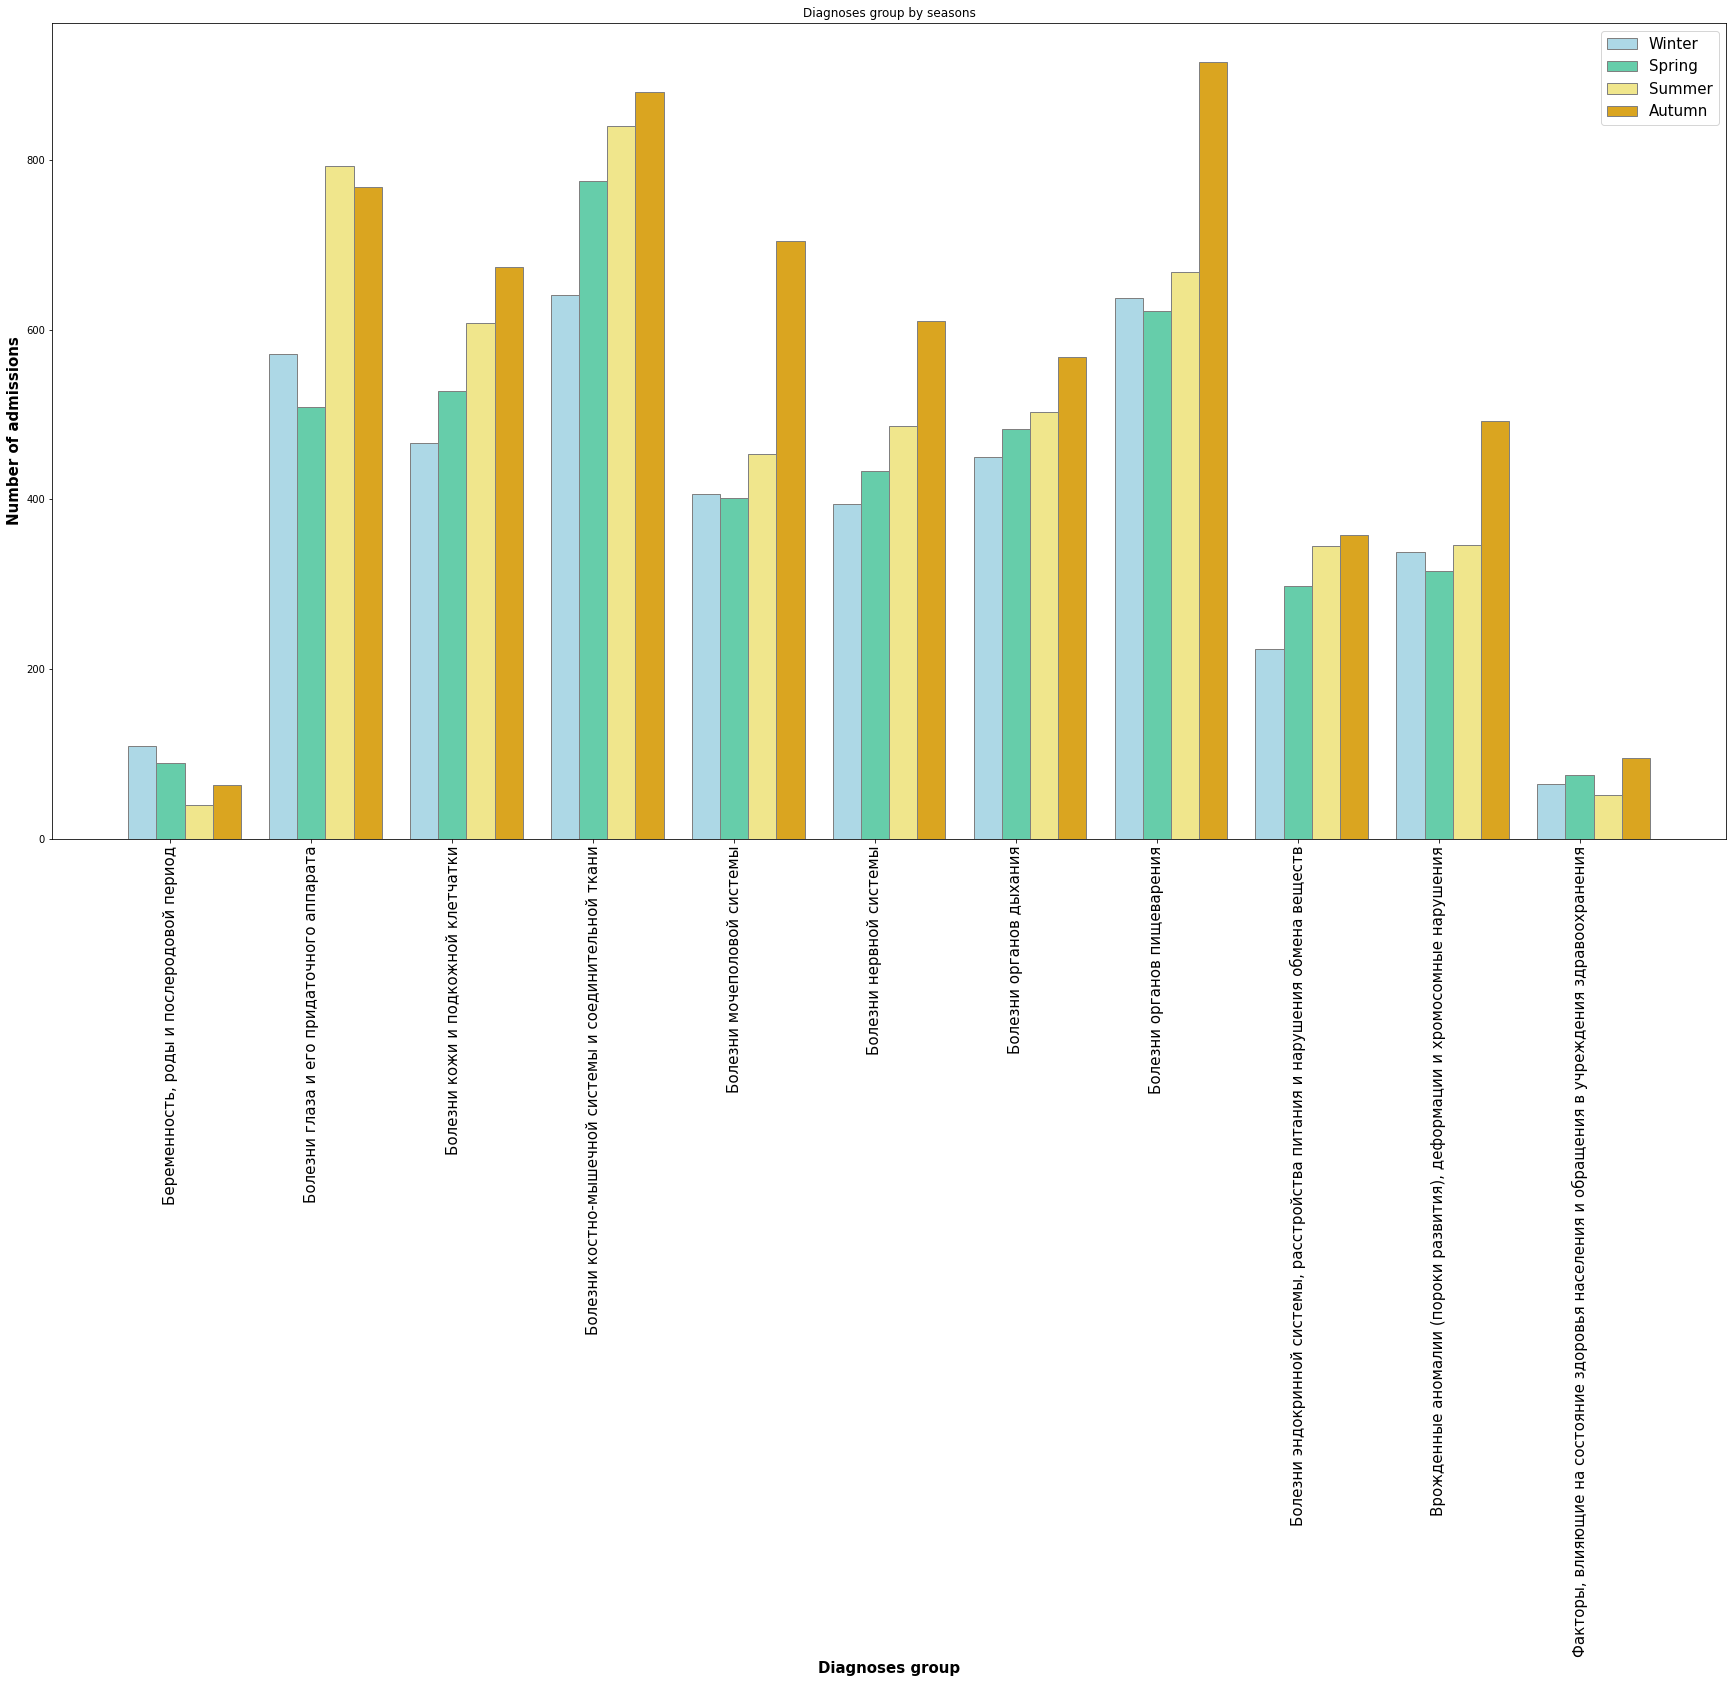

In [147]:
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(30, 15))

# set height of bar
Зима = season_diagnosis['1 winter']
Весна = season_diagnosis['2 spring']
Лето = season_diagnosis['3 summer']
Осень = season_diagnosis['4 autumn']

# Set position of bar on X axis
br1 = np.arange(len(Зима))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, Зима, color ='lightblue', width = barWidth,
        edgecolor ='grey', label ='Winter')
plt.bar(br2, Весна, color ='mediumaquamarine', width = barWidth,
        edgecolor ='grey', label ='Spring')
plt.bar(br3, Лето, color ='khaki', width = barWidth,
        edgecolor ='grey', label ='Summer')
plt.bar(br4, Осень, color ='goldenrod', width = barWidth,
        edgecolor ='grey', label ='Autumn')

# Adding Xticks
plt.xlabel('Diagnoses group', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of admissions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Зима))],
        season_diagnosis['group_mkb'].tolist(), rotation = 90, fontsize = 15)

plt.legend(fontsize = 15)
plt.title("Diagnoses group by seasons")
plt.show()


**Total**
 - Majority of diagnoses groups show growth from winter to autumn with peak in autumn.
 - Group "Беременность роды и послеродовой период" declines from winter to summer, slightly increases in autumn and peaks in winter.
 - Group "Болезни глаза и придаточного аппарата" peaks in summer.